# The Truth About Airline Statistics
### by Darren Gidado

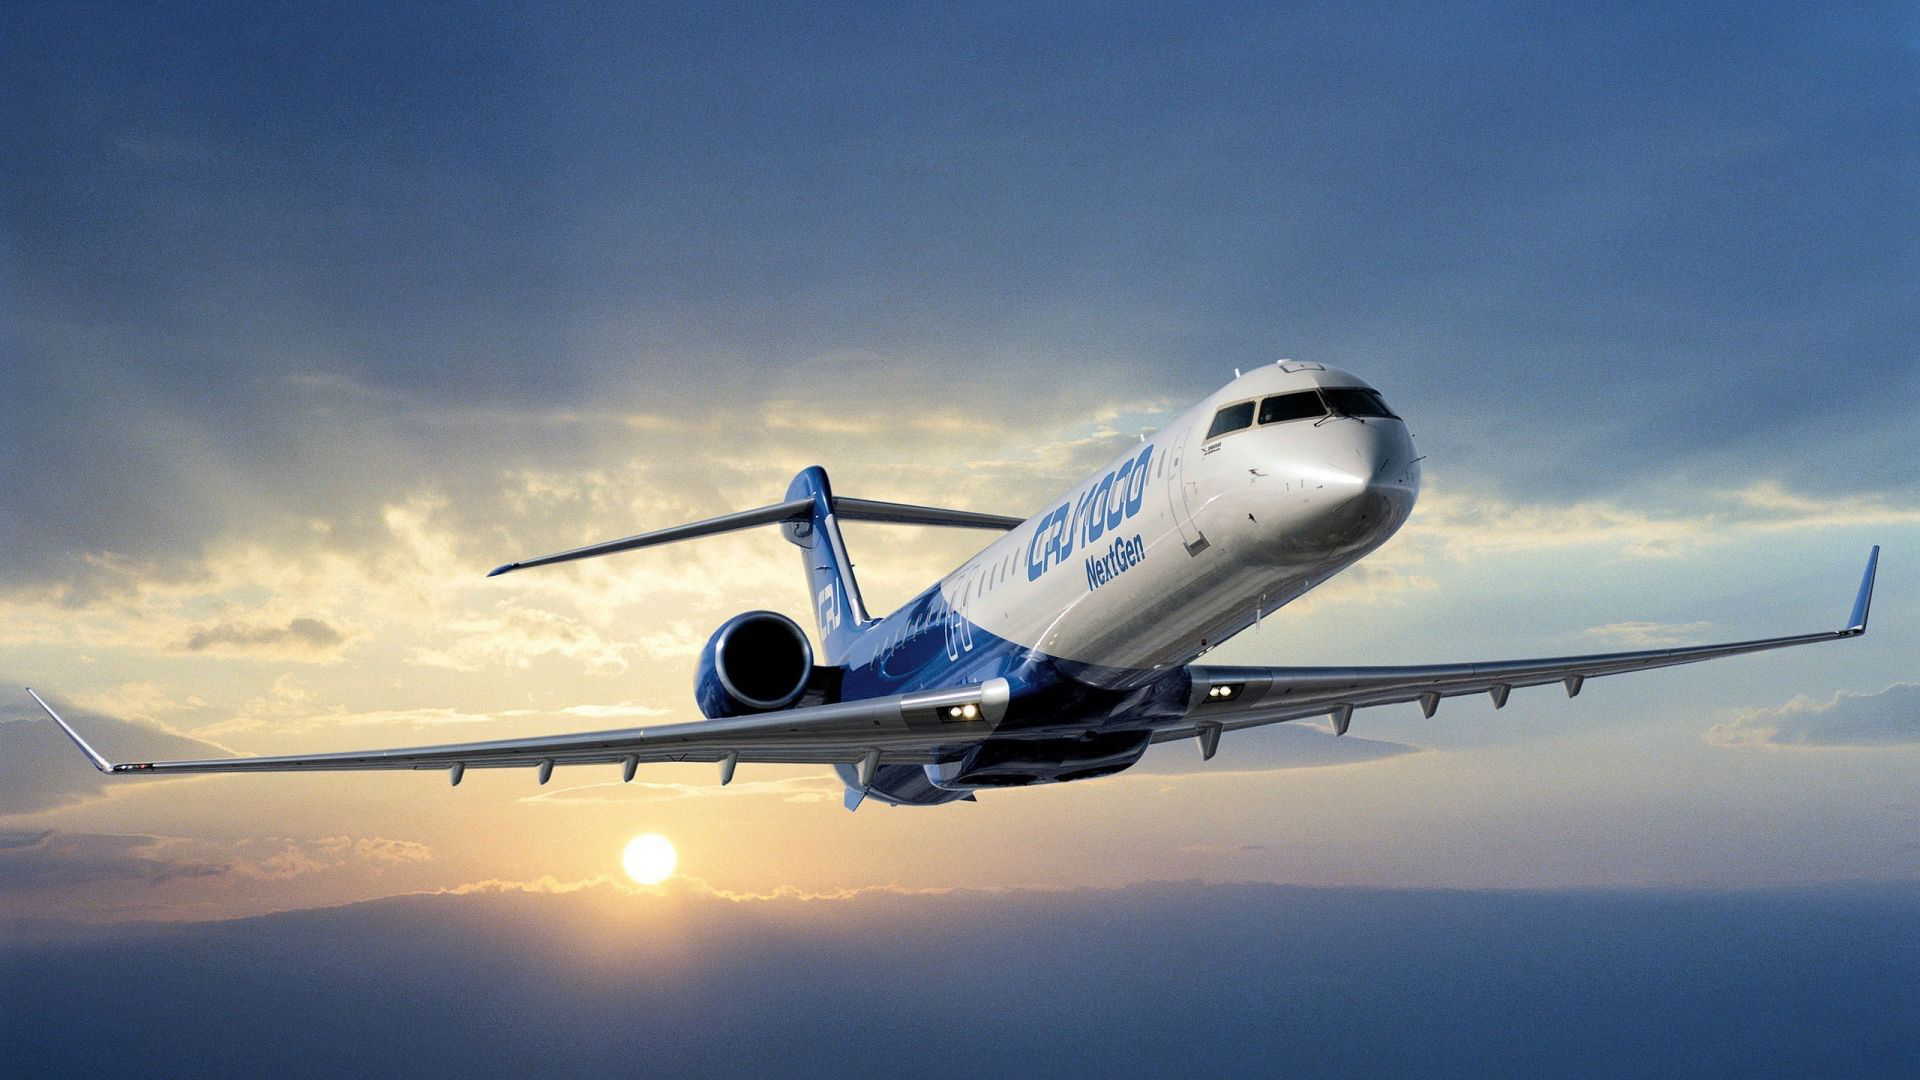

In [1]:
from PIL import Image # Library for importing images
Image.open('images/airline_cover.jpg')

## Table of Contents 📋
- [Introduction](#intro)
- [Step 1: Importing Libraries](#import)
- [Step 2: Gathering Data](#gather)
- [Step 3: Univariate Exploration](#univariate)
- [Step 4: Bivariate Exploration](#bivariate)
- [Step 5: Multivariate Exploration](#multivariate)
- [Step 6: Random Exploration](#random)
- [Step 7: Conclusion](#conclusion)

<a id='intro'></a>
## Introduction 🛫

#### What is the ASA?

ASA stands for 'American Statistical Association', ASA is the main professional organsiation for statisticians in the United States. The organization was formed in November 1839 and is the second oldest continuously operating professional society in the United States. Every other year, at the Joint Statistical Meetings, the Graphics Section and the Computing Section join in sponsoring a special Poster Session called The Data Exposition , but more commonly known as The Data Expo. All of the papers presented in this Poster Session are reports of analyses of a common data set provided for the occasion. In addition, all papers presented in the session are encouraged to report the use of graphical methods employed during the development of their analysis and to use graphics to convey their findings.

Quoted from citation: https://www.tandfonline.com/doi/abs/10.1198/jcgs.2011.1de

#### What is the ASA 2009 Data Expo?

The ASA Statistical Computing and Graphics Data Expo is a bi-annual data exploration challenge. Participants are challenged to provide a graphical summary of important features of the data. The task is intentionally vague to allow different entries to focus on different aspects of the data, giving the participants maximum freedom to apply their skills. The 2009 data expo consisted of flight arrival and departure details for all commercial flights on major carriers within the USA, from October 1987 to April 2008. This is a large dataset: there are nearly 120 million records in total, and takes up 1.6 gigabytes of space compressed and 12 gigabytes when uncompressed. The complete dataset and challenge are available on the competition website http://stat-computing.org/dataexpo/2009/.

Because the dataset is so large, we also provided participants introductions to useful tools for dealing with this scale of data: Linux command line tools, including sort, awk, and cut, and sqlite, a simple SQL database. Additionally, we provided pointers to supplemental data on airport locations, airline carrier codes, individual plane information, and weather.
This dataset reports flights in the United States, including carriers, arrival and departure delays, and reasons for delays, from 1987 to 2008.

Quoted from citation: https://www.tandfonline.com/doi/abs/10.1198/jcgs.2011.1de

#### Project Aims

This dataset reports flights in the United States, including carriers, arrival and departure delays, and reasons for delays, from 1987 to 2008. For our analysis, we are going to be using the three year period between 1989 to 1991 as our sample dataset as the whole dataset is too large to practically observe with Jupyter. Our goal is to ask many questions such as:

- How many flights are there?
- Which airlines have the most flights?
- What time of the week passengers fly the most?
- How does season change the frequency and the destination of travel?
- Which routes are the most popular?
- Which routes and airports experience the most delays?
- Which airports are the busiest in terms of inbound and outbound flights?
- Which popular routes are delayed the most?
- Which times are airports the busiest in terms of flights by each hour?
- How does flight distance affect departure and arrival delays?
- Which airline experiences the fewest delays?

**Table column descriptions:**

In [2]:
import pandas as pd
pd.read_csv('misc_data/master/variable-descriptions_master.csv')

name                                        description
0                Year                                          1987-2008
1               Month                                             12-Jan
2          DayofMonth                                             31-Jan
3           DayOfWeek                            1 (Monday) - 7 (Sunday)
4             DepTime                actual departure time (local, hhmm)
5          CRSDepTime             scheduled departure time (local, hhmm)
6             ArrTime                  actual arrival time (local, hhmm)
7          CRSArrTime               scheduled arrival time (local, hhmm)
8       UniqueCarrier                                unique carrier code
9           FlightNum                                      flight number
10            TailNum                                  plane tail number
11  ActualElapsedTime                                         in minutes
12     CRSElapsedTime                                         in minutes
13            AirTime                                         in minutes
14           ArrDelay                          arrival delay, in minutes
15           DepDelay                        departure delay, in minutes
16             Origin                           origin IATA airport code
17               Dest                      destination IATA airport code
18           Distance                                           in miles
19             TaxiIn                           taxi in time, in minutes
20            TaxiOut                           taxi out time in minutes
21          Cancelled                          was the flight cancelled?
22   CancellationCode  reason for cancellation (A = carrier, B = weat...
23           Diverted                                    1 = yes, 0 = no
24       CarrierDelay                                         in minutes
25       WeatherDelay                                         in minutes
26           NASDelay                                         in minutes
27      SecurityDelay                                         in minutes
28  LateAircraftDelay                                         in minutes

<a id='import'></a>
## Step 1: Import 📚

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import datetime as dt
import markdown
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
%matplotlib inline

# Suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# Display dataframe all columns
pd.set_option('display.max_rows', 636)
pd.set_option('display.max_columns', 636)

**References:** \
https://unicode.org/emoji/charts/full-emoji-list.html \
https://getemoji.com/

In [4]:
# Formatting ticks for large values (this will change the large numbers in charts to short clean values)
def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

<a id='gather'></a>
## Step 2: Gather 💾

In [5]:
# flight data
df8991 = pd.read_csv('dataset/1989-1991.csv')

In [6]:
# misc_data
airports = pd.read_csv('misc_data/master/airports_master.csv')
carriers = pd.read_csv('misc_data/master/carriers_master.csv')
plane_data = pd.read_csv('misc_data/master/plane-data_master.csv')
var_desc = pd.read_csv('misc_data/master/variable-descriptions_master.csv')

In [7]:
df8991.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15031014 entries, 0 to 15031013
Data columns (total 17 columns):
Date                 object
DayOfWeek            object
DepTime              object
CRSDepTime           object
ArrTime              object
CRSArrTime           object
UniqueCarrier        object
FlightNum            int64
ActualElapsedTime    int64
CRSElapsedTime       int64
ArrDelay             int64
DepDelay             int64
Origin               object
Dest                 object
Distance             int64
Cancelled            int64
Diverted             int64
dtypes: int64(8), object(9)
memory usage: 1.9+ GB


In [8]:
# Converting date column
df8991['Date'] = pd.to_datetime(df8991['Date'])

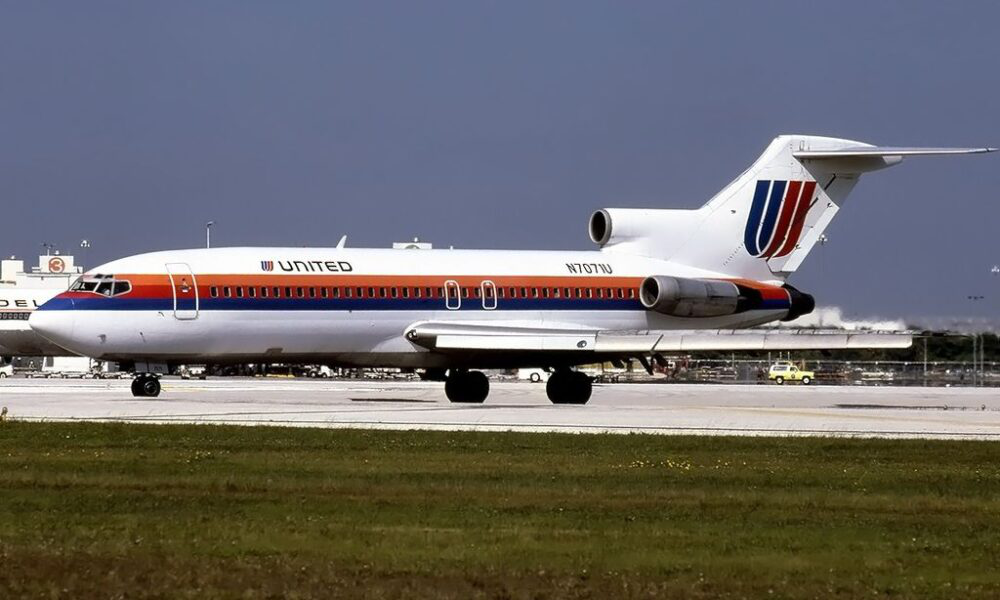

In [9]:
from PIL import Image # Library for importing images
Image.open('images/Boeing_727-22_United_Airlines.jpg')

<a id='univariate'></a>
## Step 3: Univariate Exploration 📈

During this step, we will investigate distributions of individual variables to prepare for observing the relationships between variables.

In [10]:
df8991.head(10)

Date  DayOfWeek   DepTime CRSDepTime   ArrTime CRSArrTime  \
0 1989-01-23     Monday  14:19:00   12:30:00  17:42:00   15:52:00   
1 1989-01-24    Tuesday  12:55:00   12:30:00  16:12:00   15:52:00   
2 1989-01-25  Wednesday  12:30:00   12:30:00  15:33:00   15:52:00   
3 1989-01-26   Thursday  12:30:00   12:30:00  15:23:00   15:52:00   
4 1989-01-27     Friday  12:32:00   12:30:00  15:13:00   15:52:00   
5 1989-01-28   Saturday  12:28:00   12:30:00  15:50:00   15:52:00   
6 1989-01-29     Sunday  16:39:00   12:30:00  19:42:00   15:52:00   
7 1989-01-30     Monday  12:31:00   12:30:00  15:31:00   15:52:00   
8 1989-01-31    Tuesday  14:05:00   12:30:00  18:27:00   15:52:00   
9 1989-01-02     Monday  10:57:00   10:45:00  15:37:00   15:54:00   

  UniqueCarrier  FlightNum  ActualElapsedTime  CRSElapsedTime  ArrDelay  \
0            UA        183                323             322       110   
1            UA        183                317             322        20   
2            UA        183                303             322       -19   
3            UA        183                293             322       -29   
4            UA        183                281             322       -39   
5            UA        183                322             322        -2   
6            UA        183                303             322       230   
7            UA        183                300             322       -21   
8            UA        183                382             322       155   
9            UA        184                160             189       -17   

   DepDelay Origin Dest  Distance  Cancelled  Diverted  
0       109    SFO  HNL      2398          0         0  
1        25    SFO  HNL      2398          0         0  
2         0    SFO  HNL      2398          0         0  
3         0    SFO  HNL      2398          0         0  
4         2    SFO  HNL      2398          0         0  
5        -2    SFO  HNL      2398          0         0  
6       249    SFO  HNL      2398          0         0  
7         1    SFO  HNL      2398          0         0  
8        95    SFO  HNL      2398          0         0  
9        12    DEN  IAD      1452          0         0

### 3.1. Total Flights by Month

In [11]:
# Extracting the month number from the dates
flight_month = df8991['Date'].dt.month

# Assigning the months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Creating a new dataframe
flight_month = pd.DataFrame(flight_month)

# Renaming the column name of the new dataframe
flight_month.rename(columns = {'Date':'Month'},inplace=True)

# Adding a new column to count flights per month
flight_month['Flights'] = df8991['Date'].dt.month.count

# Grouping the data by month then assigning month names to 'month' column
month_data  = flight_month.groupby('Month').count()
month_data['Month'] = months

# Renaming each month number to a real month name
flights_by_month = month_data.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
flights_by_month.drop(columns=['Month'], axis=1, inplace=True)

# Looking at the dataframe we created
flights_by_month

Flights
Month         
Jan    1223834
Feb    1102190
Mar    1271415
Apr    1250728
May    1281666
Jun    1255135
Jul    1299911
Aug    1312995
Sep    1254058
Oct    1297516
Nov    1224153
Dec    1257413

In [12]:
# Total flights
flights_by_month['Flights'].sum()

15031014

In [13]:
# Average flights per month
flights_by_month['Flights'].mean()

1252584.5

In [14]:
# Working out percentage of flights in 'Feb' compared to the monthly average
round(flights_by_month.loc['Feb','Flights']/flights_by_month['Flights'].mean()-1, 2)

-0.12

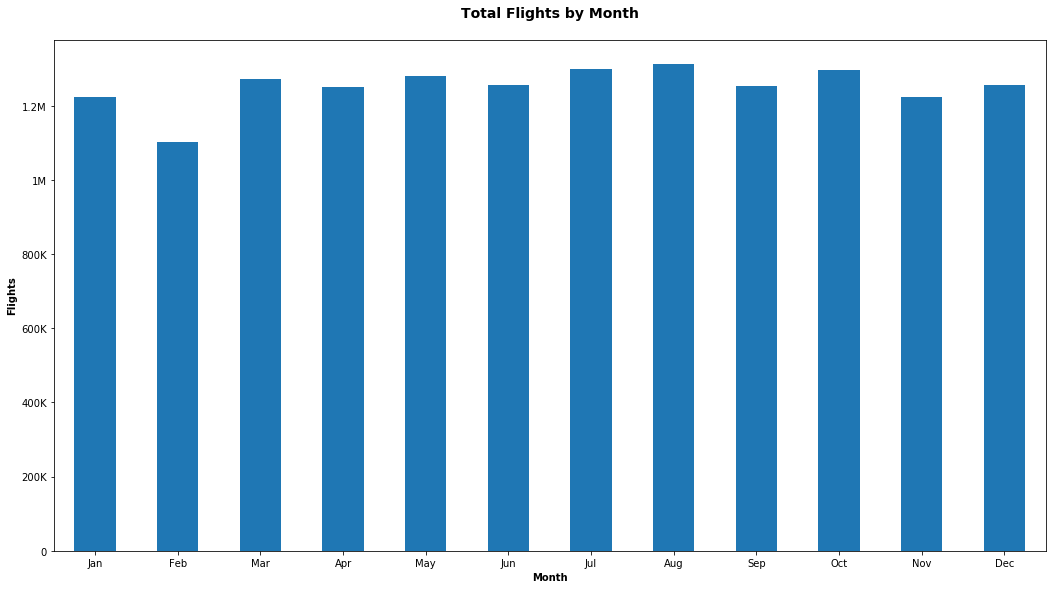

In [15]:
# Plot
flights_by_month.plot(kind = 'bar', figsize=(14.70, 8.27), rot=0, legend=None)

# Set title label
plt.title('Total Flights by Month\n', fontsize = 14, weight = "bold")

# Set axis labels
plt.ylabel('Flights', fontsize = 10,  weight = "bold")
plt.xlabel('Month', fontsize = 10, weight = "bold")

# Ticks
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/total_flights_by_month.png')
plt.show()

**Observation 1:** For this dataset we have used the data between 1989-1991, therefore we grouped the data into monthly averages between those years. can see August has the most flights on average and Feburary had the least. This shows us that summer months have the most flights and winter months the least. Feburary had 12% less flights compared to the monthly average of 1,252,585.

### 3.2. Total Flights by Season

In [16]:
# Create new dataframe
flights_by_season = flights_by_month
flights_by_season = month_data.rename(index={1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})

# Drop 'Month' column
flights_by_season.drop(columns=['Month'], axis=1, inplace=True)

# Group seasons
flights_by_season.rename_axis(index={'Month':'Season'}, inplace=True)
flights_by_season.reset_index(inplace=True)
flights_by_season = flights_by_season.groupby('Season').sum()

# Order index
flights_by_season = flights_by_season.reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

# Looking at the dataframe we created
flights_by_season

Flights
Season         
Spring  3803809
Summer  3868041
Autumn  3775727
Winter  3583437

In [17]:
flights_by_season['Flights'].pct_change(periods=1)

Season
Spring         NaN
Summer    0.016886
Autumn   -0.023866
Winter   -0.050928
Name: Flights, dtype: float64

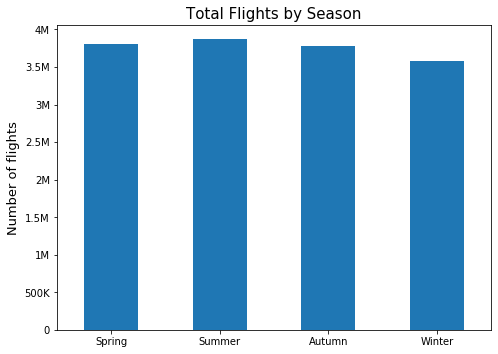

In [18]:
# Plot
flights_by_season.plot(kind = 'bar', figsize=(7, 5), rot=0, legend=None)

# Set title label
plt.title('Total Flights by Season', fontsize = 15)

# Set axis labels
plt.ylabel('Number of flights', fontsize = 13)
plt.xlabel('', fontsize = 13)

# Ticks
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/total_flights_by_season.png')
plt.show()

**Observation 2:** Here we are looking at flights by season, this plot shows us the total flights recorded for each season. Summer has the most total flights but the difference between them is not as much as you might think. From my calculations, the percentage difference between the best and worst seasons is only 5%. Spring has a strong performance placing 2nd, Autumn 3rd and Winter a more distant 4th.

### 3.3. Total Flights by Day

In [19]:
# Extracting the day number from the dates
flight_day = df8991['Date'].dt.dayofweek 

# Assigning the days
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Creating a new dataframe
flight_day = pd.DataFrame(flight_day)

# Renaming the column name of the new dataframe
flight_day.rename(columns = {'Date':'Day'},inplace=True)

# Adding a new column to count flights per day
flight_day['Flights'] = df8991['Date'].dt.dayofweek.count

# Grouping the data by day
day_data  = flight_day.groupby('Day').count()
day_data['Day'] = days

# Renaming each day number to a real day name
flights_by_day = day_data.rename(index={0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
flights_by_day.drop(columns=['Day'], axis=1, inplace=True)

# Looking at the dataframe we created
flights_by_day

Flights
Day         
Mon  2211445
Tue  2210868
Wed  2200217
Thu  2186411
Fri  2180619
Sat  1964556
Sun  2076898

In [20]:
flights_by_day['Flights'].pct_change()

Day
Mon         NaN
Tue   -0.000261
Wed   -0.004818
Thu   -0.006275
Fri   -0.002649
Sat   -0.099083
Sun    0.057184
Name: Flights, dtype: float64

In [21]:
# Average flights per day
round(flights_by_day['Flights'].mean(), 2)

2147287.71

In [22]:
# Working out percentage of flights compared to the weekly average
round(flights_by_day.loc['Sat','Flights']/flights_by_day['Flights'].mean()-1, 2)

-0.09

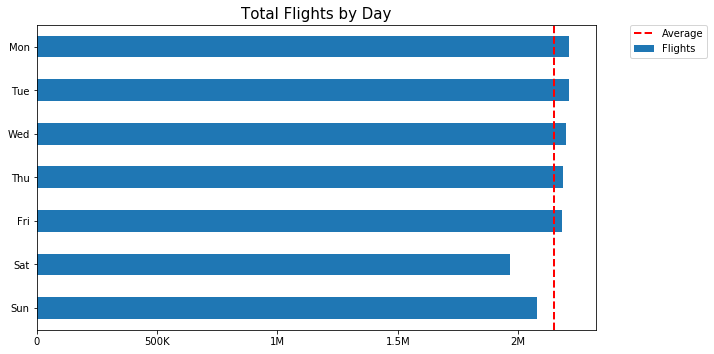

In [23]:
# Plot
flights_by_day.reindex(index=flights_by_day.index[::-1]).plot(kind = 'barh', figsize=(10, 5), rot=0)

# Set title label
plt.title('Total Flights by Day', fontsize = 15)

# Set axis labels
plt.ylabel('', fontsize = 13)
plt.xlabel('', fontsize = 13)

# Ticks
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
ax.axvline(flights_by_day['Flights'].mean(), color='red', linewidth=2, linestyle='dashed', label='Average')

# Legend
plt.legend(bbox_to_anchor=(1.2, 1), loc=1, borderaxespad=0.0)

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/total_flights_by_day.png')
plt.show()

**Observation 3:** This plot shows us total flights by day. Monday has the most total flights with 2,211,445 but the difference between Monday and the other weekdays is rather negligable. Saturday shows a near 10% dip in flights compared to Monday while Sunday dips under 6% using the same comparison, this suggests passengers are flying more during the week than weekends. This chart shows a 10% variance between the day with the highest and lowest amount of flights, 3 years of data shows consistency in strong demand for flights regardless of the day of the week.

### 3.4. Total Flights by Hour

In [24]:
# Creating flight_hour
flight_hour = df8991['DepTime']

# Creating a new dataframe
flight_hour = pd.DataFrame(flight_hour)

# Extracting the hour from the times
flight_hour['FlightHour'] = df8991['DepTime'].str[:2]

# Adding a new column to count flights per hour
flight_hour['Flights'] = flight_hour['FlightHour'].count

# Drop column
flight_hour.drop(columns=['DepTime'], axis=1, inplace=True)

# Grouping the data by hour
hour_data  = flight_hour.groupby('FlightHour').count()
flights_by_hour = hour_data

# Looking at the dataframe we created
flights_by_hour

Flights
FlightHour         
00            61648
01            46131
02             8595
03             2593
04             5505
05            53452
06           779935
07          1049654
08          1103998
09           976624
10           834899
11           915756
12           977161
13          1032993
14           845945
15           882206
16           934469
17           988229
18           973944
19           842436
20           798213
21           503912
22           275905
23           136811

In [25]:
# Most popular flight hours
flights_by_hour.sort_values(by='Flights', ascending=False).head(5)

Flights
FlightHour         
08          1103998
07          1049654
13          1032993
17           988229
12           977161

In [26]:
# Least popular flight hours 
flights_by_hour.sort_values(by='Flights', ascending=True).head(5)

Flights
FlightHour         
03             2593
04             5505
02             8595
01            46131
05            53452

In [27]:
# Working out x difference in flights between busiest hour compared to the quietest hour
round(flights_by_hour.loc['08','Flights']/flights_by_hour.loc['03','Flights'], 2)

425.76

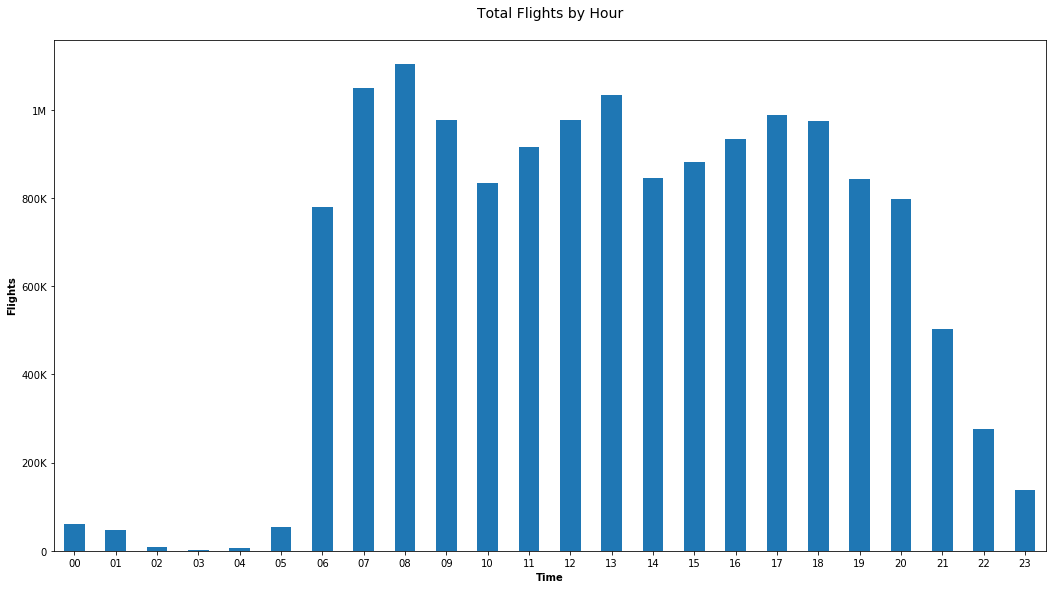

In [28]:
# Plot
flights_by_hour.plot(kind = 'bar', figsize=(14.70, 8.27), rot=0, legend=None)

# Set title label
plt.title('Total Flights by Hour\n', fontsize = 14)

# Set axis labels
plt.ylabel('Flights', fontsize = 10,  weight = "bold")
plt.xlabel('Time', fontsize = 10, weight = "bold")

# Ticks
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/total_flights_by_hour.png')
plt.show()

**Observation 4:** We can see the total flights by hour here based on departure time. 08:00 is the most popular time to fly with 1,103,998 flights according to departure time data from 1989-1991. We can see that there is a dip at 10:00, perhaps due to scheduling or other external reasons. The next dip we see on the chart is at 14:00 hours before recovering again until 18:00 where the flights steadily drop off. 03:00 recorded the lowest number of flights at only 2,593, that is a -426x difference in total flights vs 08:00. Flights between midnight and 05:00 are lower due to many factors including being the time people are generally sleeping but also noise restrictions. Maybe we can look at flight duration next?

### 3.5. Flight Duration in Minutes

In [29]:
df8991['ActualElapsedTime'].min(), df8991['ActualElapsedTime'].max()

(-591, 1883)

In [30]:
df8991['CRSElapsedTime'].min(), df8991['CRSElapsedTime'].max()

(-59, 1565)

In [31]:
df8991[df8991['CRSElapsedTime'] == -59]

Date DayOfWeek   DepTime CRSDepTime   ArrTime CRSArrTime  \
13266400 1991-08-08  Thursday  06:56:00   07:00:00  11:04:00   07:01:00   

         UniqueCarrier  FlightNum  ActualElapsedTime  CRSElapsedTime  \
13266400            NW        312                188             -59   

          ArrDelay  DepDelay Origin Dest  Distance  Cancelled  Diverted  
13266400       243        -4    MSP  DCA       931          0         0

In [32]:
# Looking for 'ActualElapsedTime' values under 0
df8991['ActualElapsedTime'][df8991['ActualElapsedTime'] < 0].count()

29

In [33]:
# Looking for 'CRSElapsedTime' values under 0
df8991['CRSElapsedTime'][df8991['CRSElapsedTime'] < 0].count()

12

In [34]:
# Creating flight_duration and dropping time values under 0
flight_duration = df8991['ActualElapsedTime'][df8991['ActualElapsedTime'] >= 0]

# Creating a new dataframe
flight_duration = pd.DataFrame(flight_duration)

# Extracting the duration data
flight_duration['FlightDuration'] = df8991['ActualElapsedTime']

# Adding a new column to count flights by duration
flight_duration['Flights'] = flight_duration['FlightDuration'].count

# Drop column
flight_duration.drop(columns=['ActualElapsedTime'], axis=1, inplace=True)

# Grouping the data by duration
duration_data  = flight_duration.groupby('FlightDuration').count()
flights_by_duration = duration_data

# Looking at the dataframe we created
flights_by_duration.head()

Flights
FlightDuration         
0                     2
1                     2
2                     4
3                     1
4                     3

In [35]:
# Average flight duration
df8991['ActualElapsedTime'][df8991['ActualElapsedTime'] > 0].mean()

109.90256206131029

In [36]:
# Median flight duration
df8991['ActualElapsedTime'][df8991['ActualElapsedTime'] > 0].median()

91.0

In [37]:
# Percentage of flights over 300 minutes
df8991['ActualElapsedTime'][df8991['ActualElapsedTime'] > 300].count()/df8991['ActualElapsedTime'].count()

0.018513654501286475

In [38]:
# Percentage of flights between 0 and 300 minutes
df8991['ActualElapsedTime'][df8991['ActualElapsedTime'].between(0, 300)].count()/df8991['ActualElapsedTime'].count()

0.9814844161544923

In [39]:
# Checking the statistics
df8991['ActualElapsedTime'][df8991['ActualElapsedTime'] > 0].describe()

count    1.503098e+07
mean     1.099026e+02
std      6.445965e+01
min      1.000000e+00
25%      6.400000e+01
50%      9.100000e+01
75%      1.400000e+02
max      1.883000e+03
Name: ActualElapsedTime, dtype: float64

In [40]:
# Maximum flight duration
df8991['ActualElapsedTime'].max()

1883

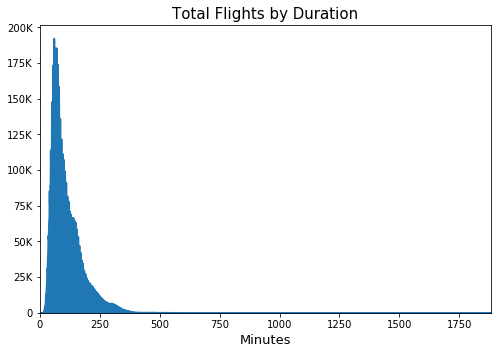

In [41]:
# Plot
flights_by_duration.plot(kind = 'area', figsize=(7, 5), rot=0, legend=None)

# Set title label
plt.title('Total Flights by Duration', fontsize = 15)

# Set axis labels
plt.ylabel('', fontsize = 13)
plt.xlabel('Minutes', fontsize = 13)

# Ticks
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/total_flights_by_duration.png')
plt.show()

**Observation 5:** Total flights by duration shows us a lot of interesting insights. Our area graph above shows us flights average around 110 minutes while the median flight duration is 91 minutes. The longest flight duration was 1883 minutes which equates to over 31 hours! The conclusion is 98.1% of flights are under 300 minutes and the remaining 1.9% of flights are generally under 300 minutes or 5 hours. Distance is an ideal thing to look at next, how far do passengers travel and does flight distance vary depending on time?

### 3.6. Flight Distance in Miles

In [42]:
# Creating flight_distance
flight_distance = df8991['Distance']

# Creating a new dataframe
flight_distance = pd.DataFrame(flight_distance)

# Extracting the distance data
flight_distance['FlightDistance'] = df8991['Distance']

# Adding a new column to count flights by distance
flight_distance['Flights'] = flight_distance['FlightDistance'].count

# Drop column
flight_distance.drop(columns=['Distance'], axis=1, inplace=True)

# Grouping the data by distance
distance_data  = flight_distance.groupby('FlightDistance').count()
flights_by_distance = distance_data
flights_by_distance_idx = distance_data.reset_index()

# Looking at the dataframe we created
flights_by_distance.head()

Flights
FlightDistance         
0                     1
11                  889
17                    4
18                    2
21                 5696

In [43]:
# Minimum and maxiumum distance travelled
df8991['Distance'].min(), df8991['Distance'].max()

(0, 4502)

In [44]:
# Average flight distance
df8991['Distance'].mean()

632.9591811969572

In [45]:
df8991['Distance'][df8991['Distance'] > 2800].count()/df8991['Distance'].count()

0.0016491901344779533

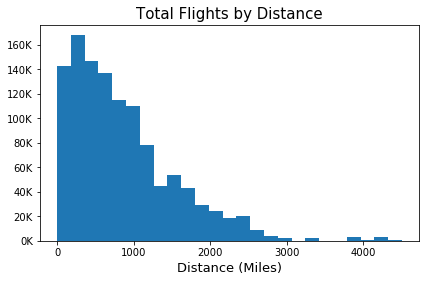

In [46]:
# Plot
plt.hist(data = flights_by_distance_idx, x = 'FlightDistance', bins = 25) #, y = 'Flights'

# Set title label
plt.title('Total Flights by Distance', fontsize = 15)

# Set axis labels
plt.ylabel('', fontsize = 13)
plt.xlabel('Distance (Miles)', fontsize = 13)

# Ticks fixed for histogram
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1) + 'K'))

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/total_flights_by_distance.png')
plt.show()

**Observation 6:** We are looking at total flights by distance using a histogram, flights are indicated on the left and distance is on the bottom. Most flights range from around 100 to 1000 miles and steadily decline after, with the average being 632 miles. 2500-3000 miles seems to be the point flights most drastically reduce. Statistically 0.1% of flights go over 2800 miles. Maybe we can look at carrier data to find some different correlations?

### 3.7. Flights by Carrier

In [47]:
# Creating flight_carrier
flight_carrier = df8991['UniqueCarrier']

# Creating a new dataframe
flight_carrier = pd.DataFrame(flight_carrier)

# Extracting the carrier data
flight_carrier['FlightCarrier'] = df8991['UniqueCarrier']

# Adding a new column to count flights by carrier
flight_carrier['Flights'] = flight_carrier['FlightCarrier'].count

# Drop column
flight_carrier.drop(columns=['UniqueCarrier'], axis=1, inplace=True)

# Grouping the data by carrier
carrier_data  = flight_carrier.groupby('FlightCarrier').count()
flights_by_carrier = carrier_data

# Looking at the dataframe we created
flights_by_carrier.head()

Flights
FlightCarrier         
AA             2084513
AS              267975
CO             1241287
DL             2430469
EA              398362

In [48]:
# Creating a filtered database for top 10 carriers ascending
carriers_top_10 = flights_by_carrier.sort_values('Flights', ascending=False).iloc[0:10]

# Dataframe without index
carriers_top_10_idx = carriers_top_10.reset_index()

In [49]:
# Top 10 Carriers
carriers_top_10

Flights
FlightCarrier         
US             2575160
DL             2430469
AA             2084513
UA             1774850
NW             1352989
CO             1241287
WN              950837
TW              756992
HP              623477
EA              398362

In [50]:
carriers.head()

code                    description
0  02Q                  Titan Airways
1  04Q             Tradewind Aviation
2  05Q            Comlux Aviation, AG
3  06Q  Master Top Linhas Aereas Ltd.
4  07Q            Flair Airlines Ltd.

In [51]:
# Filter
carriers[carriers['code'] == 'US']

code                                        description
1308   US  US Airways Inc. (Merged with America West 9/05...

In [52]:
# Renaming column to prepare for df merge
carriers_top_10_idx.rename(columns={"FlightCarrier":"code"}, inplace=True)

In [53]:
# Merging dataframes to get the carrier description
carriers_top_10_idx2 = pd.merge(left=carriers_top_10_idx, right=carriers, how='left', on='code')

In [54]:
carriers_top_10_idx2

code  Flights                                        description
0   US  2575160  US Airways Inc. (Merged with America West 9/05...
1   DL  2430469                               Delta Air Lines Inc.
2   AA  2084513                             American Airlines Inc.
3   UA  1774850                              United Air Lines Inc.
4   NW  1352989                            Northwest Airlines Inc.
5   CO  1241287                         Continental Air Lines Inc.
6   WN   950837                             Southwest Airlines Co.
7   TW   756992                            Trans World Airways LLC
8   HP   623477  America West Airlines Inc. (Merged with US Air...
9   EA   398362                             Eastern Air Lines Inc.

In [55]:
carriers_top_10_idx2['description'] = carriers_top_10_idx2['description'].str.replace(r"\(.*\)","")

In [56]:
carriers_top_10_idx2

code  Flights                  description
0   US  2575160             US Airways Inc. 
1   DL  2430469         Delta Air Lines Inc.
2   AA  2084513       American Airlines Inc.
3   UA  1774850        United Air Lines Inc.
4   NW  1352989      Northwest Airlines Inc.
5   CO  1241287   Continental Air Lines Inc.
6   WN   950837       Southwest Airlines Co.
7   TW   756992      Trans World Airways LLC
8   HP   623477  America West Airlines Inc. 
9   EA   398362       Eastern Air Lines Inc.

In [57]:
carriers_top_10_idx2['Flights'].pct_change()

0         NaN
1   -0.056187
2   -0.142341
3   -0.148554
4   -0.237688
5   -0.082559
6   -0.233991
7   -0.203868
8   -0.176376
9   -0.361064
Name: Flights, dtype: float64

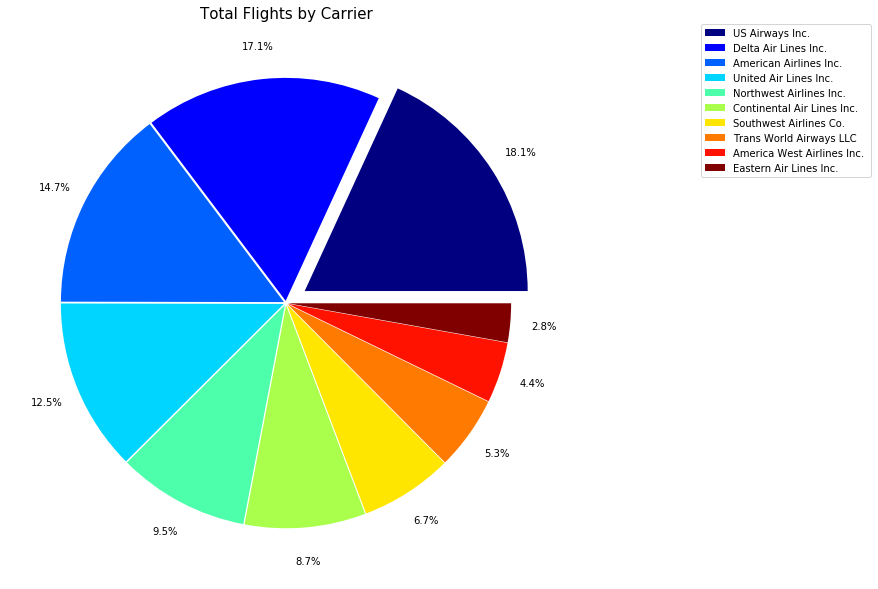

In [58]:
# Variables
labels = [' ',' ',' ',' ',' ',' ',' ',' ',' ',' ']
explode = [0.1, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

# Plot
carriers_top_10.plot(kind='pie', figsize=(14.70, 8.27), rot=0, subplots=True, labels=labels, legend=True, 
                     cmap='jet', autopct='%1.1f%%', pctdistance=1.15, explode=explode)

# Legend
carrier_list = list(carriers_top_10_idx2['description'])
plt.legend(labels = carrier_list, bbox_to_anchor=(1.55, 1), loc=1, borderaxespad=0.0)

# Set title label
plt.title('Total Flights by Carrier', loc='center', fontsize = 15)

# Set axis labels
plt.ylabel('', fontsize = 13)
plt.xlabel('', fontsize = 13)

# Ticks
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/total_flights_by_carrier.png')
plt.show()

**Observation 7:** The total flights by carrier is a good indication of which airlines were the most popular between 1989 and 1991. The most popular carrier is US Airways Inc with 2,575,160 flights between 1989-1991, that represents an 18.1% share of all flights from our data. Delta Air Lines Inc. is a close 2nd place with 2,430,469 or a 5.6% difference from 1st place with a 17% share of the market. Those two airlines would have gone toe to toe dominating aviation at that time. However, American Airlines Inc. features in 3rd place with 2,084,513 flights with a strong 14.7% market share. The gap widens to a 14% difference in total flights vs 1st place. This trend continues as the other airlines share smaller and smaller stakes in the market. Perhaps later we can find out which airline is the most punctual?

### 3.8. Flight Distance by Day

In [59]:
# Grouping data by day of week then sorting index
weekday_cat = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday = df8991.drop(['FlightNum'], axis=1).groupby(['DayOfWeek']).mean().reindex(weekday_cat)

# Rename index variable
idx = {"Monday": "Mon", "Tuesday":"Tue", "Wednesday":"Wed", "Thursday":"Thu", "Friday":"Fri", "Saturday":"Sat", "Sunday":"Sun"}

In [60]:
weekday.head(7)

ActualElapsedTime  CRSElapsedTime  ArrDelay  DepDelay    Distance  \
DayOfWeek                                                                      
Monday            109.058930      109.488231  4.964975  5.425532  628.187534   
Tuesday           109.530635      109.422163  6.213578  6.144185  627.741170   
Wednesday         109.712301      109.355599  7.021518  6.684452  627.115591   
Thursday          110.101038      109.411749  8.744248  8.079987  627.562929   
Friday            110.096784      109.529341  9.349141  8.810754  628.533479   
Saturday          110.790458      112.260839  4.769930  6.301211  650.885998   
Sunday            110.143351      111.337036  5.055255  6.310329  643.155490   

           Cancelled  Diverted  
DayOfWeek                       
Monday           0.0       0.0  
Tuesday          0.0       0.0  
Wednesday        0.0       0.0  
Thursday         0.0       0.0  
Friday           0.0       0.0  
Saturday         0.0       0.0  
Sunday           0.0       0.0

In [61]:
weekday['Distance']

DayOfWeek
Monday       628.187534
Tuesday      627.741170
Wednesday    627.115591
Thursday     627.562929
Friday       628.533479
Saturday     650.885998
Sunday       643.155490
Name: Distance, dtype: float64

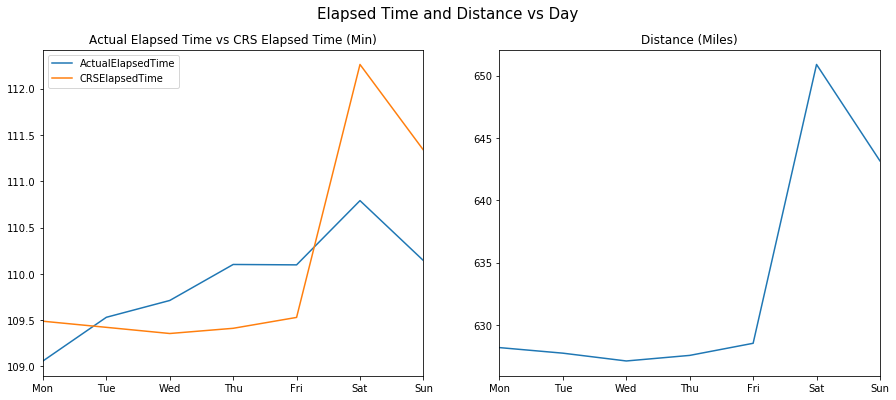

In [62]:
# Figsize
fig = ax.get_figure()
plt.figure(figsize = [15, 6])
plt.suptitle('Elapsed Time and Distance vs Day', fontsize=15)

# Plot 1
plt.subplot(1, 2, 1)
weekday['ActualElapsedTime'].rename(index = idx, inplace = False).plot(kind = 'line', title='Actual Elapsed Time', legend=None)
plt.xlabel('')
plt.ylabel('')

# Plot 2
plt.subplot(1, 2, 1)
weekday['CRSElapsedTime'].rename(index = idx, inplace = False).plot(kind = 'line', title='Actual Elapsed Time vs CRS Elapsed Time (Min)', legend=None)
plt.legend()
plt.xlabel('')
plt.ylabel('')

# Plot 3
plt.subplot(1, 2, 2)
weekday['Distance'].rename(index = idx, inplace = False).plot(kind = 'line', title='Distance (Miles)', legend=None)
plt.xlabel('')
plt.ylabel('')

# Show
fig.tight_layout()
fig.subplots_adjust(top=2)
plt.savefig('images/charts/time_vs_distance_vs_day.png')
plt.show()

**Observation 8:** Elapsed time and distance versus day is a good way to find correlation between time of the week and flight delays with distance. Flight time seems to increase as the week passes. The weekend has the longest flights on average, indicating passengers might be travelling on weekend holidays but commute on weekdays. We also know from other data that fewer flights take place during the weekend but also delays are lower while flight duration and distance is longer on average. We should look into delays more, which airports are the most punctual and which are the least?

### 3.9. Delay by Origin and Destination

In [63]:
df8991['Origin'].unique()

array(['SFO', 'DEN', 'HNL', 'LIH', 'PHL', 'OGG', 'IAD', 'EWR', 'LAX',
       'KOA', 'ORD', 'MKE', 'IAH', 'MSY', 'RIC', 'SEA', 'FLL', 'MCO',
       'BWI', 'HOU', 'MCI', 'SJC', 'CMH', 'OMA', 'ORF', 'BOS', 'ABQ',
       'SMF', 'OKC', 'SGF', 'SLC', 'ONT', 'SAN', 'BUF', 'LGB', 'MIA',
       'BDL', 'IND', 'TPA', 'SYR', 'PIT', 'STL', 'PDX', 'CLT', 'PHX',
       'CVG', 'MBS', 'ATL', 'DSM', 'LAS', 'AUS', 'JAN', 'MEM', 'DTW',
       'SRQ', 'MSP', 'DFW', 'PSP', 'MDT', 'FAT', 'BGR', 'PWM', 'ROC',
       'MDW', 'FAR', 'CHS', 'SAV', 'LGA', 'ANC', 'FSD', 'OAK', 'CLE',
       'CAE', 'TUL', 'HPN', 'GSO', 'RDU', 'DAY', 'GRR', 'MSN', 'JAX',
       'BNA', 'COS', 'SAT', 'CID', 'PBI', 'GEG', 'LNK', 'PVD', 'BIL',
       'SBA', 'ELP', 'SDF', 'TUS', 'SNA', 'ICT', 'BUR', 'ABE', 'RAP',
       'GTF', 'LIT', 'ALB', 'RNO', 'BHM', 'HSV', 'BOI', 'DCA', 'SUX',
       'TYS', 'MHT', 'EUG', 'MLI', 'BTV', 'PIA', 'FAI', 'MFR', 'MRY',
       'JFK', 'RSW', 'ERI', 'PHF', 'PSC', 'ISP', 'AVP', 'EVV', 'ELM',
       'LEX', 'ORH',

In [64]:
origin = df8991.drop(['FlightNum'], axis=1).groupby(['Origin']).mean()

In [65]:
dest = df8991.drop(['FlightNum'], axis=1).groupby(['Dest']).mean()

In [66]:
origin['DepDelay'].sort_values(ascending=False).iloc[0:10]

Origin
PSE    22.716667
YAP    19.763158
SUN    14.538462
HDN    12.525217
JFK    11.455878
ORD    10.036105
GUC     9.815362
JNU     9.490426
EWR     8.866009
PIT     8.842862
Name: DepDelay, dtype: float64

In [67]:
# Assigning high and low airport delay
aplow_delay = (origin['DepDelay'].sort_values(ascending=False)+dest['ArrDelay']).sort_values(ascending=True).iloc[0:10].sort_values(ascending=False)
aphigh_delay = (origin['DepDelay'].sort_values(ascending=False)+dest['ArrDelay']).sort_values(ascending=False).iloc[0:10].sort_values(ascending=True)

In [68]:
# Top 10 lowest delay airports
aplow_delay.sort_values(ascending=True)

BQN   -10.351648
ATW    -5.999804
YKM     0.053702
MOT     0.203609
EAU     0.944523
PMD     1.263444
ROP     1.655739
LFT     2.202046
PUB     2.252053
GRB     2.559022
dtype: float64

In [69]:
# Top 10 highest delay airports
aphigh_delay.sort_values(ascending=False)

PSE    53.250000
SUN    38.038462
YAP    37.362168
HDN    22.337867
GST    20.760290
SIT    20.030887
GUC    19.211647
JFK    18.920419
JNU    18.902215
SFO    18.836069
dtype: float64

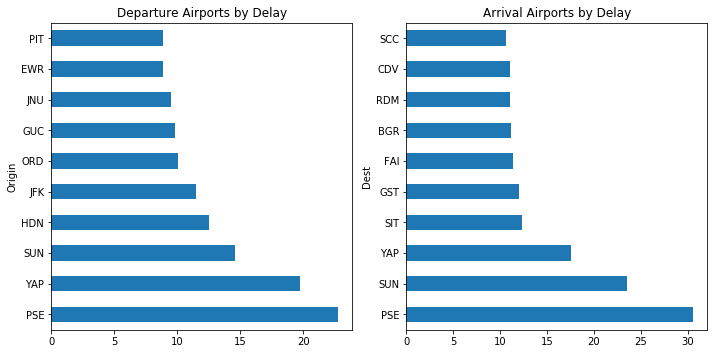

In [70]:
# Chart 1
plt.subplot(1, 2, 1)
origin['DepDelay'].sort_values(ascending=False).iloc[0:10].plot(
    kind = 'barh', figsize=(10, 5), legend=None, title='Departure Airports by Delay')

# Chart 2
plt.subplot(1, 2, 2)
dest['ArrDelay'].sort_values(ascending=False).iloc[0:10].plot(
    kind = 'barh', figsize=(10, 5), legend=None, title='Arrival Airports by Delay', label='Delay in minutes')

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/delay_by_origin_dest.png')
plt.show()

Here we are looking at airports ranked by average delay times. PIT is has the lowest departure delays but PSE has the highest departure delays on average. SCC has the lowest arrival delays and PSE has the highest departure delays. We should look at total delay now, this should be easily done by adding the departure and arrival times. 

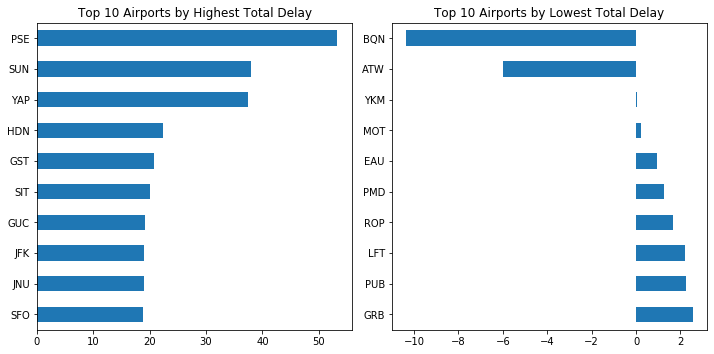

In [71]:
# Chart 1
plt.subplot(1, 2, 1)
aphigh_delay.plot(
    kind = 'barh', figsize=(10, 5), legend=None, title='Top 10 Airports by Highest Total Delay')

# Chart 2
plt.subplot(1, 2, 2)
aplow_delay.plot(
    kind = 'barh', figsize=(10, 5), legend=None, title='Top 10 Airports by Lowest Total Delay')

# Show
plt.tight_layout(pad=1)
plt.savefig('images/charts/delay_by_airport.png')
plt.show()

**Observation 9:** The above plot shows airports by total delay this time. PSE - Mercedita Airport has the highest average delays at 53.2 minutes. BQN - Rafael Hernández Airport has the lowest average delays at -10.35 minutes. In other words, flights arrive 10 minutes early on average.

In [72]:
# Airline carrier filter
carriers[carriers['code'] == 'UA']

code            description
1297   UA  United Air Lines Inc.

In [73]:
# Airport name filter
airports[airports['iata'] == 'PSE']

iata    airport   city state country        lat       long
2674  PSE  Mercedita  Ponce    PR     USA  18.008303 -66.563012

In [74]:
# Airports by flights
(df8991['Origin'] == 'ATW').sum()+(df8991['Dest'] == 'ATW').sum()

1861

<a id='bivariate'></a>
## Step 4: Bivariate Exploration 📈

### 4.1. Airports by Traffic

In [75]:
df8991['Dest'].unique()

array(['HNL', 'IAD', 'SFO', 'DEN', 'LIH', 'LAX', 'PDX', 'ORD', 'KOA',
       'OGG', 'BOS', 'EWR', 'IAH', 'MSY', 'PHX', 'OMA', 'ABE', 'SDF',
       'DFW', 'PHL', 'BTV', 'FAT', 'DTW', 'ABQ', 'TUL', 'AUS', 'MSP',
       'PIT', 'GSO', 'SMF', 'TUS', 'IND', 'GRR', 'HOU', 'ORF', 'SJC',
       'SAN', 'CMH', 'SEA', 'MCI', 'MEM', 'BDL', 'TPA', 'PBI', 'FSD',
       'BWI', 'DSM', 'CVG', 'MCO', 'MHT', 'PWM', 'BGR', 'BOI', 'RDU',
       'LAS', 'DAY', 'SAV', 'CHS', 'FAI', 'ANC', 'CLE', 'OAK', 'ICT',
       'OKC', 'MKE', 'GEG', 'LIT', 'TYS', 'BNA', 'BUF', 'COS', 'FAR',
       'SGF', 'LNK', 'SUX', 'RAP', 'GTF', 'BIL', 'CLT', 'ONT', 'SLC',
       'ATL', 'STL', 'MIA', 'MSN', 'MRY', 'JAX', 'MBS', 'CAE', 'RNO',
       'HPN', 'ROC', 'ALB', 'RSW', 'RIC', 'SBA', 'SAT', 'LGB', 'PVD',
       'HSV', 'MDT', 'JAN', 'DCA', 'BUR', 'JFK', 'SNA', 'PSP', 'SYR',
       'FLL', 'BHM', 'MLI', 'PIA', 'CID', 'SRQ', 'LGA', 'MDW', 'ELP',
       'EUG', 'MFR', 'ERI', 'AVP', 'ISP', 'PSC', 'EVV', 'MYR', 'GSP',
       'PHF', 'ITH',

In [76]:
# Extracting the month number from the dates
flight_dest = df8991['Date'].dt.month

# Assigning the months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Creating a new dataframe
flight_dest = pd.DataFrame(flight_dest)

# Renaming the column name of the new dataframe
flight_dest.rename(columns = {'Date':'Month'},inplace=True)

# Adding a new column to count flights per month
flight_dest['Flights'] = df8991['Date'].dt.month.count

# Adding a new column to sum destinations per month
flight_dest['Dest'] = df8991['Dest']

# Grouping the data by month then assigning month names to 'month' column
month_dest  = flight_dest.groupby([('Month'),('Dest')]).count()

# Renaming each month number to a real month name
flights_by_dest = month_dest.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Looking at the dataframe we created
flights_by_dest.head()

Flights
Month Dest         
Jan   ABE      1281
      ABQ      7264
      ACY       160
      AGS       780
      ALB      3203

In [77]:
flights_by_dest_piv = flights_by_dest.reset_index().pivot(columns='Month',index='Dest',values='Flights')
flights_by_dest_piv = flights_by_dest_piv.reindex(columns= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

In [78]:
flights_by_dest_piv.head()

Month     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep  \
Dest                                                                            
ABE    1281.0  1155.0  1169.0  1151.0  1276.0  1319.0  1499.0  1508.0  1490.0   
ABQ    7264.0  6549.0  7691.0  7645.0  7947.0  7708.0  7900.0  7909.0  7580.0   
ACY     160.0   144.0   163.0   162.0   209.0   211.0   249.0   242.0   188.0   
AGS     780.0   703.0   782.0   747.0   796.0   789.0   796.0   809.0   784.0   
ALB    3203.0  2989.0  3260.0  3215.0  3256.0  3160.0  3238.0  3312.0  3193.0   

Month     Oct     Nov     Dec  
Dest                           
ABE    1599.0  1540.0  1519.0  
ABQ    7826.0  7281.0  7311.0  
ACY     190.0   182.0   184.0  
AGS     810.0   789.0   823.0  
ALB    3356.0  3097.0  3165.0

In [79]:
flights_by_dest_piv.columns

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'],
      dtype='object', name='Month')

In [80]:
flights_by_dest_piv.sort_values(by=['Dest'], axis=0, ascending=False).head()

Month    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
Dest                                                                          
YUM    463.0  412.0  451.0  435.0  411.0  372.0  374.0  404.0  364.0  391.0   
YKM     60.0   51.0   55.0   59.0    1.0    NaN    NaN    NaN    NaN    NaN   
YAP     42.0   38.0   47.0   52.0   54.0   24.0   20.0   27.0   26.0   23.0   
YAK    160.0  121.0  166.0  171.0  168.0  164.0  173.0  174.0  152.0  166.0   
WRG     63.0   64.0   77.0   83.0   87.0   86.0   81.0   84.0   78.0   85.0   

Month    Nov    Dec  
Dest                 
YUM    373.0  430.0  
YKM      NaN    NaN  
YAP     24.0   27.0  
YAK    151.0  144.0  
WRG     59.0   62.0

In [81]:
# Filling NaN with 0
flights_by_dest_piv = flights_by_dest_piv.fillna(0)

# Changing from float to np.int64 to remove .0
flights_by_dest_piv = flights_by_dest_piv.astype(np.int64)

# Summing across the rows using .sum and 'axis=0'
flights_by_dest_piv['Total'] = flights_by_dest_piv.sum(axis=1).astype(np.int64)

In [82]:
top_10_dest = flights_by_dest_piv.sort_values(by='Total', ascending=False).iloc[0:10,0:12]
top_10_dest

Month    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
Dest                                                                          
ORD    64860  58108  66654  66439  68519  66286  67693  68390  65764  67931   
DFW    38769  34937  58998  58056  59562  59201  61925  62389  60610  61807   
ATL    57380  51969  51962  50441  52188  52102  55742  58388  58889  62291   
LAX    39072  34862  39950  39503  41515  41261  42912  42905  39996  41003   
DEN    33867  30862  35191  34093  34796  34488  35836  36688  33778  34459   
PHX    32979  29793  34678  33877  34737  33711  34804  34720  32948  34131   
STL    30506  27696  31060  30712  31455  31567  32828  33232  31617  32362   
SFO    30068  26649  30753  30482  31827  31614  32985  33238  30755  31824   
DTW    29098  26382  29715  29650  30752  29824  30642  31366  29435  30746   
PIT    29062  26246  29307  28722  29731  28558  29588  29576  28745  29720   

Month    Nov    Dec  
Dest                 
ORD    63949  66085  
DFW    59015  61795  
ATL    59045  60404  
LAX    39004  39192  
DEN    32398  34396  
PHX    32723  33877  
STL    29153  29462  
SFO    29794  30346  
DTW    28619  29245  
PIT    28388  28690

In [83]:
df8991['Dest'].value_counts().head(10)

ORD    790678
DFW    677064
ATL    670801
LAX    481175
DEN    410852
PHX    402978
STL    371650
SFO    370335
DTW    355474
PIT    346333
Name: Dest, dtype: int64

In [84]:
df8991['Origin'].value_counts().head(10)

ORD    774861
ATL    669767
DFW    662101
LAX    482516
DEN    405662
PHX    400611
SFO    374001
STL    366913
DTW    349453
PIT    343552
Name: Origin, dtype: int64

In [85]:
# Extracting the month number from the dates
flight_origin = df8991['Date'].dt.month

# Assigning the months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Creating a new dataframe
flight_origin = pd.DataFrame(flight_origin)

# Renaming the column name of the new dataframe
flight_origin.rename(columns = {'Date':'Month'},inplace=True)

# Adding a new column to count flights per month
flight_origin['Flights'] = df8991['Date'].dt.month.count

# Adding a new column to sum origininations per month
flight_origin['Origin'] = df8991['Origin']

# Grouping the data by month then assigning month names to 'month' column
month_origin  = flight_origin.groupby([('Month'),('Origin')]).count()

# Renaming each month number to a real month name
flights_by_origin = month_origin.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Looking at the dataframe we created
flights_by_origin.head()

Flights
Month Origin         
Jan   ABE        1301
      ABQ        7335
      ACY         163
      AGS         788
      ALB        3268

In [86]:
flights_by_origin_piv = flights_by_origin.reset_index().pivot(columns='Month',index='Origin',values='Flights')
flights_by_origin_piv = flights_by_origin_piv.reindex(columns= ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

In [87]:
# Filling NaN with 0
flights_by_origin_piv = flights_by_origin_piv.fillna(0)

# Changing from float to np.int64 to remove .0
flights_by_origin_piv = flights_by_origin_piv.astype(np.int64)

# Summing across the rows using .sum and 'axis=0'
flights_by_origin_piv['Total'] = flights_by_origin_piv.sum(axis=1).astype(np.int64)

In [88]:
top_10_origin = flights_by_origin_piv.sort_values(by='Total', ascending=False).iloc[0:10,0:12]
top_10_origin

Month     Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
Origin                                                                         
ORD     63683  57104  65155  65023  67217  64757  66369  66467  64726  66832   
ATL     57224  51831  51889  50462  52186  51917  55763  58313  58726  62141   
DFW     37532  34338  57383  56859  58287  57753  60299  60768  59686  60774   
LAX     39260  34981  40132  39607  41546  41426  42986  43020  40053  41105   
DEN     33559  30592  34759  33763  34374  33898  35128  36124  33433  34119   
PHX     32876  29661  34464  33563  34596  33422  34562  34440  32777  33942   
SFO     30341  27027  31162  30702  32088  31962  33370  33629  30964  32088   
STL     30176  27306  30606  30396  31023  31093  32449  32837  31197  31883   
DTW     28584  25911  29229  29155  30192  29321  30138  30906  28979  30265   
PIT     28787  26041  29022  28528  29542  28366  29325  29314  28534  29451   

Month     Nov    Dec  
Origin                
ORD     62869  64659  
ATL     58936  60379  
DFW     57928  60494  
LAX     39040  39360  
DEN     31922  33991  
PHX     32553  33755  
SFO     30019  30649  
STL     28845  29102  
DTW     28131  28642  
PIT     28215  28427

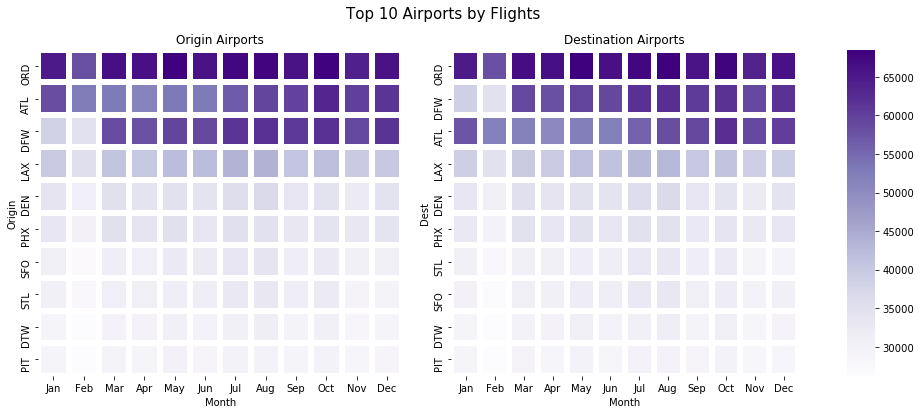

In [89]:
import seaborn as sns
fig, (ax1, ax2, axcb) = plt.subplots(1,3, figsize=(15,6), gridspec_kw={'width_ratios':[1.05,1,0.08]})

# Plot
fig.suptitle('Top 10 Airports by Flights', fontsize=15)
ax1.title.set_text('Origin Airports')
ax2.title.set_text('Destination Airports')
sns.heatmap(top_10_origin, cmap='Purples', linewidths=5, cbar=None, ax=ax1)
sns.heatmap(top_10_dest, cmap='Purples', linewidths=5, cbar_ax=axcb, ax=ax2)

# Show
#plt.tight_layout(pad=3)
plt.savefig('images/charts/top_10_airports_by_flights.png')
plt.show()

On the left shows the top 10 airports by flights departed and on the right are the destinations by flights arrived. ORD - Chicago O'Hare International has the most flights based on departure and arrivals which suggests it's a hub for flights across America. ATL - Atlanta International has the 2nd most flights based on departure but 3rd based on arrival. DFW - Dallas-Fort Worth International is 3rd in departures but 2nd in arrivals, the opposite of ATL. This means flights between those two airports are common. We could delve deeper into that if we need to later.

In [90]:
# Sum dataframes
top_10_airports = top_10_origin.rename_axis(index='Airport')+top_10_dest.rename_axis(index='Airport')
top_10_airports['Total'] = top_10_airports.sum(axis=1).astype(np.int64)

# Sorting values
top_10_ap_total = top_10_airports['Total']
top_10_airports = top_10_airports.sort_values(by='Total', ascending=False).iloc[0:10,0:12]

In [91]:
# Top 10 airports by total flights
top_10_ap_total.sort_values(ascending=False)

Airport
ORD    1565539
ATL    1340568
DFW    1339165
LAX     963691
DEN     816514
PHX     803589
SFO     744336
STL     738563
DTW     704927
PIT     689885
Name: Total, dtype: int64

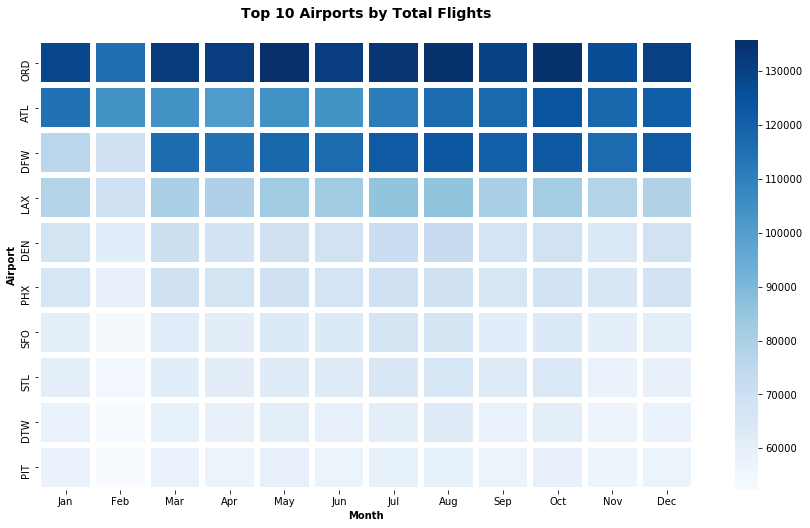

In [92]:
# Plot
fig, ax = plt.subplots(figsize=(14.70, 8.27))
sns.heatmap(top_10_airports.iloc[0:10,0:12], cmap='Blues', linewidths=5, cbar='Blues')

# Labels
ax.set_title('Top 10 Airports by Total Flights\n', fontsize=14, weight='bold')
plt.xlabel('Month'.title(),
               fontsize = 10, weight = "bold")
plt.ylabel('Airport'.title(),
               fontsize = 10, weight = "bold")

# Show
#plt.tight_layout(pad=0)
plt.savefig('images/charts/top_10_airports_by_total_flights.png')
plt.show()

**Observation 10:** This plot shows us the top 10 airports by total inbound and outbound flights. The chart is topped by Chicago O'Hare International in 1st place with 1,565,539 flights. 2nd place is William B Hartsfield-Atlanta International with 1,340,568, and close 3rd is Dallas-Fort Worth International with 1,339,165. During the summer Chicago O'Hare International is very busy with strong demand throughout the year. Atlanta International follows a similar trend but Dallas-Fort Worth International show a weak January and Feburary in terms of total flights.

In [93]:
# Dataframe without index
top_10_origin_idx = top_10_origin.reset_index().iloc[:,0:1]

# Renaming column to prepare for df merge
top_10_origin_idx.rename(columns={"Origin":"iata"}, inplace=True)

# Merging dataframes to get the airport description
top_10_origin_desc = pd.merge(left=top_10_origin_idx, right=airports, how='left', on='iata')

# Show airport data
top_10_origin_desc.iloc[:,:-2]

iata                            airport               city state country
0  ORD       Chicago O'Hare International            Chicago    IL     USA
1  ATL  William B Hartsfield-Atlanta Intl            Atlanta    GA     USA
2  DFW    Dallas-Fort Worth International  Dallas-Fort Worth    TX     USA
3  LAX          Los Angeles International        Los Angeles    CA     USA
4  DEN                        Denver Intl             Denver    CO     USA
5  PHX   Phoenix Sky Harbor International            Phoenix    AZ     USA
6  SFO        San Francisco International      San Francisco    CA     USA
7  STL     Lambert-St Louis International           St Louis    MO     USA
8  DTW  Detroit Metropolitan-Wayne County            Detroit    MI     USA
9  PIT           Pittsburgh International         Pittsburgh    PA     USA

In [94]:
top_10_origin_desc['long'].describe()

count     10.000000
mean     -98.076828
std       15.373173
min     -122.374843
25%     -110.172792
50%      -93.698595
75%      -85.296324
max      -80.232871
Name: long, dtype: float64

In [95]:
top_10_ap_total.sort_values(ascending=False)

Airport
ORD    1565539
ATL    1340568
DFW    1339165
LAX     963691
DEN     816514
PHX     803589
SFO     744336
STL     738563
DTW     704927
PIT     689885
Name: Total, dtype: int64

### 4.2. Airlines by Month vs Average Distance

In [96]:
# Creating a Unique Carrier dataframe
UC1 = df8991['UniqueCarrier'].groupby(df8991['Date'].map(lambda x: x.month)).nunique().dropna()
UC2 = round(df8991['Distance'].groupby(df8991['Date'].map(lambda x: x.month)).mean(), 2)

# Merge and reindex dataframes
carriers_month_v_distance = pd.merge(left=UC1, right=UC2, how='left', on='Date')
carriers_month_v_distance = carriers_month_v_distance.rename(index={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                                                                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
# Rename Columns
carriers_month_v_distance.rename_axis("Month", axis="index", inplace=True)
carriers_month_v_distance.rename(columns = {'UniqueCarrier':'CarrierCount'},inplace=True)

# Saving as a new dataframe
carriers_month_v_distance = pd.DataFrame(carriers_month_v_distance)

# Show
carriers_month_v_distance

CarrierCount  Distance
Month                        
Jan              14    619.77
Feb              14    623.41
Mar              14    630.20
Apr              14    628.60
May              14    629.13
Jun              14    635.24
Jul              14    640.34
Aug              14    639.94
Sep              13    635.37
Oct              13    634.70
Nov              12    636.83
Dec              12    640.03

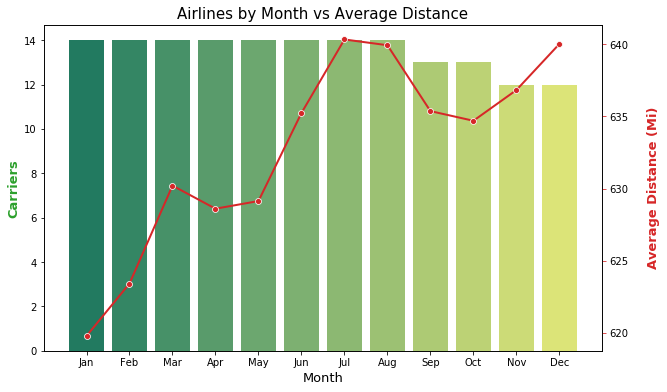

In [97]:
# Creating a combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'

# Creating Bar Plot
ax1.set_title('Airlines by Month vs Average Distance', fontsize=15)
ax1 = sns.barplot(x='Month', y='CarrierCount', data=carriers_month_v_distance.reset_index(), palette='summer')
ax1.set_xlabel('Month', fontsize=13)
ax1.set_ylabel('Carriers', fontsize=13, color=color, weight='bold')
ax1.tick_params(axis='y')

# Sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

# Creating Line Plot
ax2 = sns.lineplot(x='Month', y='Distance', data=carriers_month_v_distance.reset_index(), 
                   sort=False, color=color, linewidth = 2, marker='o')
ax2.set_ylabel('\nAverage Distance (Mi)', fontsize=13, color=color, weight='bold')
ax2.tick_params(axis='y', color=color)

# Show
#plt.tight_layout(pad=3)
plt.savefig('images/charts/airlines_by_month_vs_distance.png')
plt.show()

**Observation 11:** Above is a combination chart showing us the amount of carriers active each month along with the average distance flown. On average, we can count around 12-14 carriers on any given month but the chart shows us from September the amount of carriers reduces into December suggesting reduced holidays. The opposite seems true when we look at average distance travelled by month. This number is increaing from 620 miles on average to 640 miles suggesting fewer longer flights. This correlation suggests perhaps passengers are flying less often but further in the winter than the summer. This could mean going from a cold country to a hotter country or going to see family for the festive season in December. 

### 4.3. Average Flight Delay vs Distance

In [98]:
# Creating a dataframe
DD1 = df8991['DepDelay'].groupby(df8991['Date'].map(lambda x: x.day)).mean()
DD2 = df8991['ArrDelay'].groupby(df8991['Date'].map(lambda x: x.day)).mean()
DD3 = df8991['Distance'].groupby(df8991['Date'].map(lambda x: x.day)).mean()

# Merge and reindex dataframes
delay_v_distance = pd.merge(left=DD1, right=DD2, how='left', on='Date')
delay_v_distance = pd.merge(left=delay_v_distance, right=DD3, how='left', on='Date')

# Saving as a new dataframe
delay_v_distance = pd.DataFrame(delay_v_distance)

# Show
delay_v_distance

DepDelay  ArrDelay    Distance
Date                                
1     6.756960  6.279760  633.227517
2     7.148581  7.067214  633.218274
3     7.722741  7.702845  633.915910
4     6.065070  5.623313  633.371921
5     6.034198  5.818042  632.001161
6     6.525807  6.330133  631.732588
7     6.092675  5.939208  632.502854
8     6.242835  6.140405  632.523106
9     6.557927  6.414992  632.940562
10    6.341829  6.056148  632.540616
11    6.260230  5.892138  631.703551
12    5.819695  5.567792  630.539311
13    5.723200  5.511132  631.097914
14    6.827372  6.880148  632.665304
15    7.680069  7.815735  632.968215
16    7.398344  7.318719  633.384753
17    6.888403  6.965868  632.278565
18    6.953599  7.174428  632.314703
19    7.576420  7.859780  631.405105
20    8.048997  8.234841  632.202658
21    8.192566  8.112351  633.127681
22    8.683596  8.583389  633.981356
23    7.389391  6.976880  634.602349
24    5.878058  5.063008  634.855267
25    5.817795  5.020933  633.658841
26    6.168475  5.591412  631.978279
27    6.972767  6.594828  632.447910
28    7.683362  7.301313  634.785688
29    6.662649  6.500185  635.010834
30    6.456550  6.135588  634.696271
31    7.340170  6.895714  635.679141

In [99]:
# Delay with distance correlation
delay_v_distance.corr()

DepDelay  ArrDelay  Distance
DepDelay  1.000000  0.969679  0.305120
ArrDelay  0.969679  1.000000  0.149177
Distance  0.305120  0.149177  1.000000

In [100]:
delay_v_distance['TotalDelay'] = delay_v_distance['DepDelay']+delay_v_distance['ArrDelay']
delay_v_distance.corr()

DepDelay  ArrDelay  Distance  TotalDelay
DepDelay    1.000000  0.969679  0.305120    0.990868
ArrDelay    0.969679  1.000000  0.149177    0.993775
Distance    0.305120  0.149177  1.000000    0.221398
TotalDelay  0.990868  0.993775  0.221398    1.000000

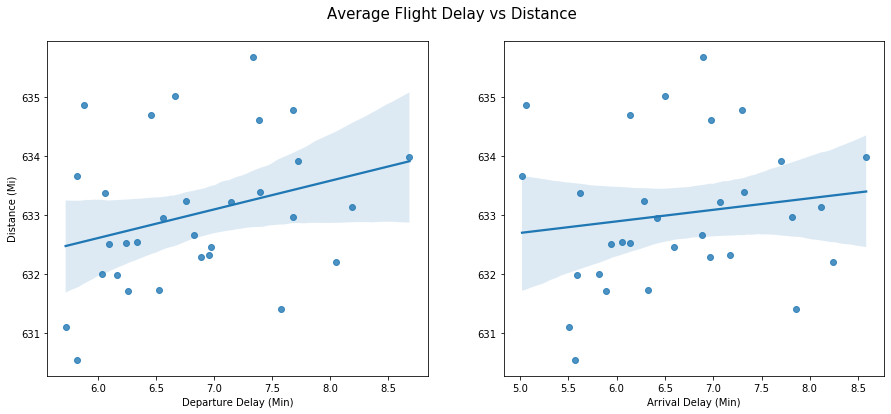

In [101]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6), gridspec_kw={'width_ratios':[1,1]})

# Plot
fig.suptitle('Average Flight Delay vs Distance', fontsize=15)
sb.regplot(data = delay_v_distance, x = 'DepDelay', y = 'Distance', ax=ax1)
sb.regplot(data = delay_v_distance, x = 'ArrDelay', y = 'Distance', ax=ax2)

# Labels
ax1.title.set_text('')
ax1.set_xlabel('Departure Delay (Min)')
ax1.set_ylabel('Distance (Mi)')

ax2.title.set_text('')
ax2.set_xlabel('Arrival Delay (Min)')
ax2.set_ylabel('')

# Show
#plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.9)
plt.savefig('images/charts/delay_vs_distance.png')
plt.show()

**Observation 12:** We used a scatterplot to show the average flight delay vs distance. Please keep in mind that we are using a daily average here to plot this data because millions of data points would not be clear. There doesn't seem to be a clear correlation between the distance and departure or arrival delay but we can clearly see one when we add a line of best fit. We can clearly observe a positive correlation in both plots indicating as the flight distance increases the greater chance of delay increases too. We can move on to delays by airline for our univariate exploration section, which airline is the most punctual and maybe we can look at delay on various flight routes?

<a id='univariate'></a>
## Step 5: Univariate Exploration 📈

### 5.1. Routes by Flights, Airline and Average Delay

In [102]:
# Dataframe from columns
flight_route = df8991[['Origin','Dest']]

# Creating a new dataframe
flight_route = pd.DataFrame(flight_route)

# Creating columns
flight_route['Route'] = flight_route['Origin'].str.cat(flight_route['Dest'],sep=" - ")
flight_route['AverageDelay'] = df8991['DepDelay']+df8991['ArrDelay']
flight_route['Carrier'] = df8991['UniqueCarrier']
flight_route.head()

Origin Dest      Route  AverageDelay Carrier
0    SFO  HNL  SFO - HNL           219      UA
1    SFO  HNL  SFO - HNL            45      UA
2    SFO  HNL  SFO - HNL           -19      UA
3    SFO  HNL  SFO - HNL           -29      UA
4    SFO  HNL  SFO - HNL           -37      UA

In [103]:
flight_route.groupby(['Carrier', 'Route'])['AverageDelay'].mean().head()

Carrier  Route    
AA       ABE - ALB    33.00000
         ABE - BDL     1.00000
         ABE - MDT    16.00000
         ABE - ORD     6.97619
         ABQ - DEN    52.00000
Name: AverageDelay, dtype: float64

In [104]:
# Top carriers by average delay 
flight_route.groupby('Carrier')['AverageDelay'].mean().sort_values(ascending=False)

Carrier
PI        25.816885
UA        16.953211
DL        15.099069
EA        14.285615
WN        14.058281
US        13.584921
TW        13.468342
CO        12.723660
HP        11.795458
AA        11.353261
ML (1)    10.940089
AS        10.922795
PA (1)     9.541804
NW         8.327834
Name: AverageDelay, dtype: float64

In [105]:
# Top routes by average delay 
flight_route.groupby('Route')['AverageDelay'].mean().sort_values(ascending=False).iloc[0:10]

Route
GUC - HDN    1980.000000
ICT - PDX     446.000000
BHM - LIT     407.000000
AMA - SLC     351.000000
MCI - ELP     271.000000
CLE - DAY     231.000000
SGF - TUL     220.333333
DCA - PHL     211.500000
TUL - MSP     204.000000
ORD - SUX     174.000000
Name: AverageDelay, dtype: float64

In [106]:
# Top carriers by total routes
flight_route.groupby('Carrier')['Route'].count().sort_values(ascending=False)

Carrier
US        2575160
DL        2430469
AA        2084513
UA        1774850
NW        1352989
CO        1241287
WN         950837
TW         756992
HP         623477
EA         398362
PI         281905
AS         267975
PA (1)     223079
ML (1)      69119
Name: Route, dtype: int64

In [107]:
# Top routes by flights
flight_route['Route'].value_counts().iloc[0:10]

SFO - LAX    69180
LAX - SFO    68754
LAX - PHX    39321
PHX - LAX    38756
LAX - LAS    31549
PHX - LAS    30778
LAS - LAX    30296
LAS - PHX    29775
LGA - ORD    29656
ORD - MSP    29308
Name: Route, dtype: int64

In [108]:
# Creating a new dataframe
top_10_flight_route = pd.DataFrame(flight_route['Route'].value_counts().iloc[0:10])
top_10_flight_route

Route
SFO - LAX  69180
LAX - SFO  68754
LAX - PHX  39321
PHX - LAX  38756
LAX - LAS  31549
PHX - LAS  30778
LAS - LAX  30296
LAS - PHX  29775
LGA - ORD  29656
ORD - MSP  29308

In [109]:
# Creating list
delay_list = []
item0 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[0]].mean())
item1 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[1]].mean())
item2 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[2]].mean())
item3 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[3]].mean())
item4 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[4]].mean())
item5 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[5]].mean())
item6 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[6]].mean())
item7 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[7]].mean())
item8 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[8]].mean())
item9 = list(flight_route[flight_route['Route'] == top_10_flight_route.reset_index()['index'].loc[9]].mean())

# Creating a new dataframe
delay_list.append(item0+item1+item2+item3+item4+item5+item6+item7+item8+item9)
top_10_flight_delay = pd.DataFrame(delay_list)
top_10_flight_delay = pd.melt(top_10_flight_delay).drop(['variable'], axis=1).rename(columns={"value":"AverageDelay"})
top_10_flight_delay.index = top_10_flight_route.index
top_10_flight_delay

AverageDelay
SFO - LAX     14.286889
LAX - SFO     18.972918
LAX - PHX     15.574909
PHX - LAX     16.178011
LAX - LAS     11.177407
PHX - LAS     15.854929
LAS - LAX     11.442567
LAS - PHX     14.501092
LGA - ORD     14.211762
ORD - MSP     14.661662

In [110]:
top_10_flight_route = pd.concat([top_10_flight_route, top_10_flight_delay], axis=1).reindex(top_10_flight_route.index)
top_10_flight_route.rename(columns={"Route":"Flights"}, inplace=True)
top_10_flight_route['AverageDelay'] = round(top_10_flight_route['AverageDelay'], 2)
top_10_flight_route.index.name = 'Route'

In [111]:
top_10_flight_route

Flights  AverageDelay
Route                           
SFO - LAX    69180         14.29
LAX - SFO    68754         18.97
LAX - PHX    39321         15.57
PHX - LAX    38756         16.18
LAX - LAS    31549         11.18
PHX - LAS    30778         15.85
LAS - LAX    30296         11.44
LAS - PHX    29775         14.50
LGA - ORD    29656         14.21
ORD - MSP    29308         14.66

In [112]:
# Creating a dataframe for average delay by route and carrier
carrier_route_delay = pd.DataFrame(flight_route.groupby(['Carrier', 'Route'])['AverageDelay'].mean())
carrier_route_delay.head()

AverageDelay
Carrier Route                  
AA      ABE - ALB      33.00000
        ABE - BDL       1.00000
        ABE - MDT      16.00000
        ABE - ORD       6.97619
        ABQ - DEN      52.00000

In [113]:
carrier_route_delay.filter(like='SFO - LAX', axis=0)

AverageDelay
Carrier Route                  
AA      SFO - LAX      6.917208
AS      SFO - LAX     20.866279
CO      SFO - LAX     12.990581
DL      SFO - LAX     13.237706
NW      SFO - LAX     20.851767
PA (1)  SFO - LAX      8.613192
TW      SFO - LAX     13.563017
UA      SFO - LAX     17.250478
US      SFO - LAX     17.044848

In [114]:
# Get index names
carrier_route_delay.index.names

FrozenList(['Carrier', 'Route'])

In [115]:
list(carrier_route_delay.index[0])

['AA', 'ABE - ALB']

In [116]:
carrier_route_delay['RouteIndex'] = carrier_route_delay.reset_index(level=0, drop=True).index #.reset_index(level=0, drop=True) #.str.extractall(r"(A-Z)").index
carrier_route_delay['RouteIndex'] = carrier_route_delay['RouteIndex']
carrier_route_delay.head()

AverageDelay RouteIndex
Carrier Route                             
AA      ABE - ALB      33.00000  ABE - ALB
        ABE - BDL       1.00000  ABE - BDL
        ABE - MDT      16.00000  ABE - MDT
        ABE - ORD       6.97619  ABE - ORD
        ABQ - DEN      52.00000  ABQ - DEN

In [117]:
carrier_route_delay['RouteIndex'].iloc[0]

'ABE - ALB'

In [118]:
carrier_route_delay.filter(like="ABE - ALB", axis=0)

AverageDelay RouteIndex
Carrier Route                             
AA      ABE - ALB          33.0  ABE - ALB

In [119]:
carrier_route_delay.filter(like=top_10_flight_route.index[1], axis=0)

AverageDelay RouteIndex
Carrier Route                             
AA      LAX - SFO      8.280271  LAX - SFO
AS      LAX - SFO     22.179775  LAX - SFO
CO      LAX - SFO     19.412461  LAX - SFO
DL      LAX - SFO     21.431304  LAX - SFO
NW      LAX - SFO     19.772613  LAX - SFO
PA (1)  LAX - SFO     21.444831  LAX - SFO
TW      LAX - SFO     32.326835  LAX - SFO
UA      LAX - SFO     20.176455  LAX - SFO
US      LAX - SFO     20.680116  LAX - SFO

In [120]:
carrier_route_delay.drop(['RouteIndex'], axis=1, inplace=True)

In [121]:
# Merge index 0-1
item0 = carrier_route_delay.filter(like=top_10_flight_route.index[0], axis=0)
item1 = carrier_route_delay.filter(like=top_10_flight_route.index[1], axis=0)
item0_1 = item0.merge(item1, how="outer", on="AverageDelay", left_index=True, right_index=True)

# Merge index 2-3
item2 = carrier_route_delay.filter(like=top_10_flight_route.index[2], axis=0)
item3 = carrier_route_delay.filter(like=top_10_flight_route.index[3], axis=0)
item2_3 = item2.merge(item3, how="outer", on="AverageDelay", left_index=True, right_index=True)
merge0_3 = item0_1.merge(item2_3, how="outer", on="AverageDelay", left_index=True, right_index=True)

# Merge index 4-5
item4 = carrier_route_delay.filter(like=top_10_flight_route.index[4], axis=0)
item5 = carrier_route_delay.filter(like=top_10_flight_route.index[5], axis=0)
item4_5 = item4.merge(item5, how="outer", on="AverageDelay", left_index=True, right_index=True)
merge0_5 = merge0_3.merge(item4_5, how="outer", on="AverageDelay", left_index=True, right_index=True)

# Merge index 6-7
item6 = carrier_route_delay.filter(like=top_10_flight_route.index[6], axis=0)
item7 = carrier_route_delay.filter(like=top_10_flight_route.index[7], axis=0)
item6_7 = item5.merge(item6, how="outer", on="AverageDelay", left_index=True, right_index=True)
merge0_7 = merge0_5.merge(item6_7, how="outer", on="AverageDelay", left_index=True, right_index=True)

# Merge index 8-9
item8 = carrier_route_delay.filter(like=top_10_flight_route.index[8], axis=0)
item9 = carrier_route_delay.filter(like=top_10_flight_route.index[9], axis=0)
item8_9 = item8.merge(item9, how="outer", on="AverageDelay", left_index=True, right_index=True)
merge0_9 = merge0_7.merge(item8_9, how="outer", on="AverageDelay", left_index=True, right_index=True)

# Print dataframe
carrier_ra = merge0_9
carrier_ra

AverageDelay
Carrier Route                  
AA      LAS - LAX     -0.577778
        LAX - LAS      1.730290
        LAX - SFO      8.280271
        LGA - ORD     14.982707
        ORD - MSP     19.809837
        SFO - LAX      6.917208
AS      LAX - SFO     22.179775
        SFO - LAX     20.866279
CO      LAS - LAX      6.295775
        LAX - LAS      2.410959
        LAX - SFO     19.412461
        SFO - LAX     12.990581
DL      LAS - LAX     11.196488
        LAX - LAS     13.751666
        LAX - PHX     16.196706
        LAX - SFO     21.431304
        PHX - LAS     24.553367
        PHX - LAX     13.126173
        SFO - LAX     13.237706
HP      LAS - LAX     13.548347
        LAX - LAS      8.688118
        LAX - PHX     13.020739
        PHX - LAS     15.177153
        PHX - LAX     15.904401
ML (1)  LAS - LAX    118.200000
        LAX - LAS     54.857143
        PHX - LAS     30.956522
NW      LAX - SFO     19.772613
        ORD - MSP     11.556449
        SFO - LAX     20.851767
PA (1)  LAX - SFO     21.444831
        SFO - LAX      8.613192
TW      LAS - LAX     17.000000
        LAX - LAS      4.000000
        LAX - PHX      5.272727
        LAX - SFO     32.326835
        ORD - MSP      7.494118
        PHX - LAS     27.221639
        PHX - LAX     76.833333
        SFO - LAX     13.563017
UA      LAS - LAX     36.938462
        LAX - LAS     17.198347
        LAX - SFO     20.176455
        LGA - ORD     13.425165
        ORD - MSP     16.037805
        PHX - LAX     16.000000
        SFO - LAX     17.250478
US      LAS - LAX      9.396913
        LAX - LAS     13.447669
        LAX - SFO     20.680116
        PHX - LAS      0.968202
        SFO - LAX     17.044848
WN      LAS - LAX     11.451827
        LAX - LAS      1.762376
        LAX - PHX     17.719184
        PHX - LAS     15.269559
        PHX - LAX     17.112161

In [122]:
# Rename column for merge
carrier_ra_idx = carrier_ra.reset_index().rename(columns={"Carrier":"code"})

# Merge to get carrier names
carrier_ra_idx = pd.merge(left=carrier_ra_idx, right=carriers, how='left', on='code')
carrier_ra_idx['description'] = carrier_ra_idx['description'].str.replace(r"\(.*\)","")
carrier_ra_idx.tail()

code      Route  AverageDelay             description
52   WN  LAS - LAX     11.451827  Southwest Airlines Co.
53   WN  LAX - LAS      1.762376  Southwest Airlines Co.
54   WN  LAX - PHX     17.719184  Southwest Airlines Co.
55   WN  PHX - LAS     15.269559  Southwest Airlines Co.
56   WN  PHX - LAX     17.112161  Southwest Airlines Co.

In [123]:
list(carrier_ra_idx.reset_index()['description'].unique())

['American Airlines Inc.',
 'Alaska Airlines Inc.',
 'Continental Air Lines Inc.',
 'Delta Air Lines Inc.',
 'America West Airlines Inc. ',
 'Midway Airlines Inc. ',
 'Northwest Airlines Inc.',
 'Pan American World Airways ',
 'Trans World Airways LLC',
 'United Air Lines Inc.',
 'US Airways Inc. ',
 'Southwest Airlines Co.']

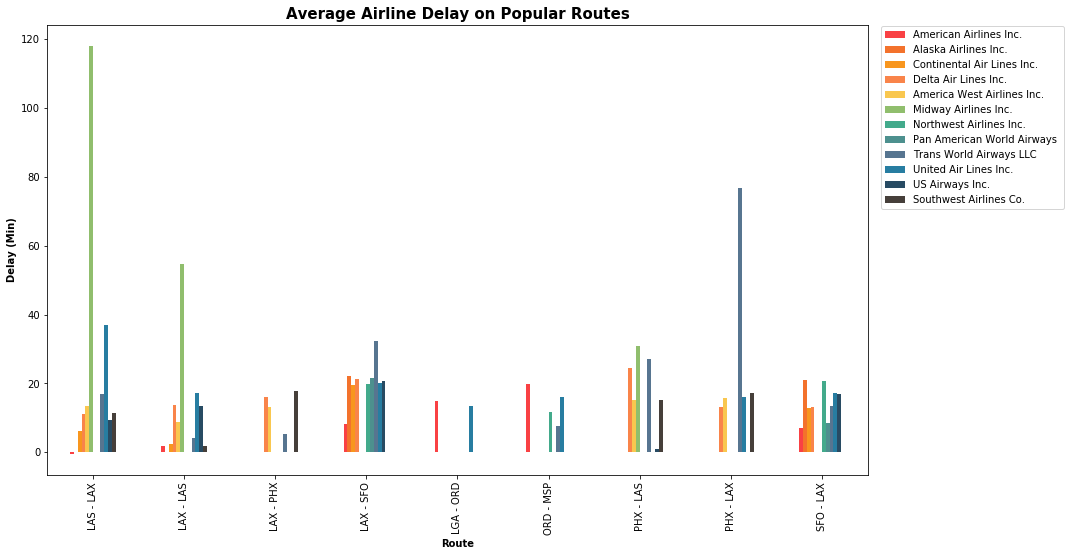

In [124]:
# Colors
colors = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1","#284b63","#463f3a"] # 12 Airlines

# Plot
carrier_ra.unstack(level=0).plot(kind='bar', figsize=(14.70, 8.27), color=colors, subplots=False)

# Title
plt.title('Average Airline Delay on Popular Routes', fontsize=15, weight='bold')

# Label
plt.xlabel('Route', weight='bold')
plt.ylabel('Delay (Min)', weight='bold')

# Legend
carrier_list = list(carrier_ra.reset_index()['Carrier'].unique())
long_carrier_list = list(carrier_ra_idx.reset_index()['description'].unique())
plt.legend(long_carrier_list, loc='0', bbox_to_anchor=(1.01, 1.01))

# Show
#plt.tight_layout(pad=3)
plt.savefig('images/charts/routes_by_flights_airline_average_delay.png')
plt.show()

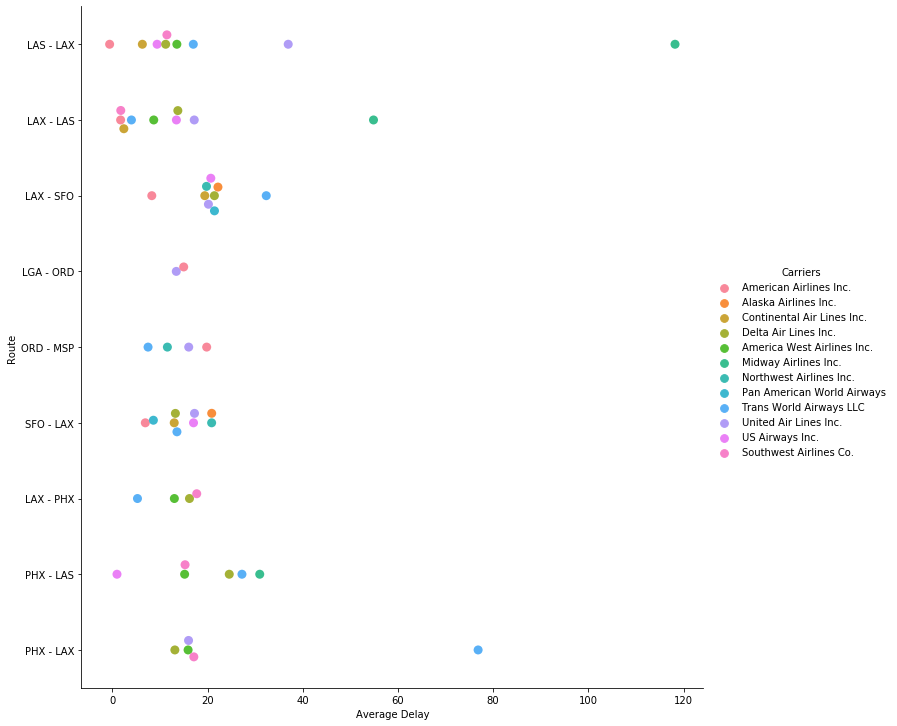

In [125]:
# Plot
g = sns.catplot(data=carrier_ra_idx, kind='swarm', x='AverageDelay', y='Route', hue='description', height=10, s=9)
g._legend.set_title("Carriers")

# Label
plt.xlabel('Average Delay')

# Show
#plt.tight_layout(pad=3)
plt.savefig('images/charts/routes_by_flights_airline_average_delay_2.png')
plt.show()

**Observation 13:** Which airline is the most punctual and which is the least? And does flight route have an affect on delay times per carrier? LAS - LAX shows us many interesting insights. For example, American Airlines has the fewest delays on this route with an average delay of just -0.57 minutes, this means they are actually early. Midway Airlines Inc. has the most delays totalling an average of 118.2 minutes on this route which is astonishing. Things don't fair too well for Midway on the return leg with an average delay of 54.8 minutes. For PHX - LAX, Trans World Airways LLC tops the charts with an average of 76.8 minutes and Delta Air Lines Inc. has the fewest delays with just 13.1 minutes for delays on average. For our final conclusion, we can say the average delay time is just 18.36 minutes if all carriers and routes are considered which is pretty good. The outlier here is the maximum delay of 118 minutes which is 644% of the delay average of 18.36 minutes. Let's see which airline is the most punctual overall, can it still be Delta Air Lines Inc?

In [126]:
# Filter route data
carrier_ra.filter(like='PHX - LAX', axis=0).sort_values(by='AverageDelay', ascending=False)

AverageDelay
Carrier Route                  
TW      PHX - LAX     76.833333
WN      PHX - LAX     17.112161
UA      PHX - LAX     16.000000
HP      PHX - LAX     15.904401
DL      PHX - LAX     13.126173

In [127]:
carrier_ra.describe()

AverageDelay
count     57.000000
mean      18.367970
std       18.243396
min       -0.577778
25%       11.196488
50%       15.269559
75%       20.176455
max      118.200000

In [128]:
# Difference between max delay and mean delay in %
carrier_ra.max()/carrier_ra.mean()*100

AverageDelay    643.511507
dtype: float64

### 5.2. Top 10 Airlines by Average Delay

In [129]:
# Dataframe from columns
top_10_carriers_by_delay = df8991['DepDelay']+df8991['ArrDelay']

# Creating a new dataframe
top_10_carriers_by_delay = pd.DataFrame(top_10_carriers_by_delay)

# Creating columns
top_10_carriers_by_delay['Carrier'] = df8991['UniqueCarrier']
top_10_carriers_by_delay.columns = ['AverageDelay','Carrier']
top_10_carriers_by_delay['DepDelay'] = df8991['DepDelay']
top_10_carriers_by_delay['ArrDelay'] = df8991['ArrDelay']

# Rename column for merge
top_10_carriers_by_delay = top_10_carriers_by_delay.rename(columns={"Carrier":"code"})

# Merge to get carrier names
top_10_carriers_by_delay = pd.merge(left=top_10_carriers_by_delay, right=carriers, how='left', on='code')
top_10_carriers_by_delay['Carrier'] = top_10_carriers_by_delay['description'].str.replace(r"\(.*\)","")
top_10_carriers_by_delay = top_10_carriers_by_delay.groupby(by='Carrier').mean().sort_values(by='AverageDelay', ascending=True)
top_10_carriers_by_delay

AverageDelay   DepDelay   ArrDelay
Carrier                                                        
Northwest Airlines Inc.          8.327834   4.487461   3.840373
Pan American World Airways       9.541804   5.263768   4.278036
Alaska Airlines Inc.            10.922795   4.882948   6.039847
Midway Airlines Inc.            10.940089   6.192480   4.747609
American Airlines Inc.          11.353261   5.929751   5.423510
America West Airlines Inc.      11.795458   6.301721   5.493738
Continental Air Lines Inc.      12.723660   6.735197   5.988463
Trans World Airways LLC         13.468342   6.699408   6.768934
US Airways Inc.                 13.584921   6.825033   6.759888
Southwest Airlines Co.          14.058281   7.946357   6.111925
Eastern Air Lines Inc.          14.285615   8.222712   6.062903
Delta Air Lines Inc.            15.099069   6.969973   8.129096
United Air Lines Inc.           16.953211   8.579475   8.373736
Piedmont Aviation Inc.          25.816885  11.974005  13.842880

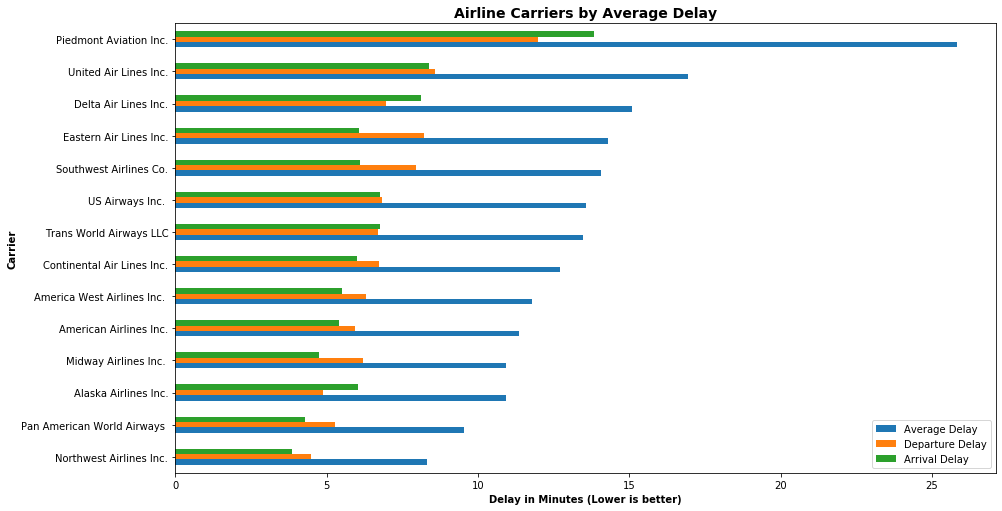

In [130]:
# Plot
top_10_carriers_by_delay.plot(kind='barh', figsize=(14.70, 8.27)) 

# Title
plt.title('Airline Carriers by Average Delay', fontsize=14, weight='bold')

# Label
plt.xlabel('Delay in Minutes (Lower is better)', fontsize=10, weight='bold')
plt.ylabel('Carrier', fontsize=10, weight='bold')

plt.legend(['Average Delay', 'Departure Delay', 'Arrival Delay'])

# Plot
plt.savefig('images/charts/airlines_by_average_delays.png')
plt.show()

**Observation 14:** Which airline is the most punctual? Northwest Airlines has the lowest average delay on flights for departure and arrival times combined. Piedmont Aviation is the least punctual carrier with almost 26 minutes average delay times with a 52% increased average delay time vs Northwest Airlines. Another trend we can notice is that departure delays are 5% higher than arrival delays on average suggesting various factors cause this like aircraft prepeation and passengers. Unfortunately Delta Air Lines Inc. is 3rd from bottom in terms of punctuality despite performing well in the most popular routes observed earlier.

In [131]:
# Departure delays vs Arrival delays % difference
top_10_carriers_by_delay['DepDelay'].mean()/top_10_carriers_by_delay['ArrDelay'].mean()-1

0.05605593713455348

In [132]:
# Percent change of delay between top 10 airlines
top_10_carriers_by_delay.pct_change()

AverageDelay  DepDelay  ArrDelay
Carrier                                                      
Northwest Airlines Inc.               NaN       NaN       NaN
Pan American World Airways       0.145773  0.172995  0.113964
Alaska Airlines Inc.             0.144731 -0.072347  0.411827
Midway Airlines Inc.             0.001583  0.268185 -0.213952
American Airlines Inc.           0.037767 -0.042427  0.142367
America West Airlines Inc.       0.038949  0.062729  0.012949
Continental Air Lines Inc.       0.078691  0.068787  0.090053
Trans World Airways LLC          0.058527 -0.005314  0.130329
US Airways Inc.                  0.008656  0.018752 -0.001336
Southwest Airlines Co.           0.034845  0.164296 -0.095854
Eastern Air Lines Inc.           0.016171  0.034778 -0.008021
Delta Air Lines Inc.             0.056942 -0.152351  0.340793
United Air Lines Inc.            0.122798  0.230919  0.030094
Piedmont Aviation Inc.           0.522832  0.395657  0.653131

<a id='random'></a>
## Step 6: Random Exploration 🔀

### 6.1. Plane Data

We can round off our exploration by looking at the `plane_data` table. There we can find data about plane types, manufacturers, models, engine types and issue dates.

In [133]:
plane_data.head()

tailnum         type      manufacturer  issue_date      model status  \
0  N10156  Corporation           EMBRAER  02/13/2004  EMB-145XR  Valid   
1  N102UW  Corporation  AIRBUS INDUSTRIE  05/26/1999   A320-214  Valid   
2  N10323  Corporation            BOEING  07/01/1997    737-3TO  Valid   
3  N103US  Corporation  AIRBUS INDUSTRIE  06/18/1999   A320-214  Valid   
4  N104UA  Corporation            BOEING  01/26/1998    747-422  Valid   

             aircraft_type engine_type  year  
0  Fixed Wing Multi-Engine   Turbo-Fan  2004  
1  Fixed Wing Multi-Engine   Turbo-Fan  1998  
2  Fixed Wing Multi-Engine   Turbo-Jet  1986  
3  Fixed Wing Multi-Engine   Turbo-Fan  1999  
4  Fixed Wing Multi-Engine   Turbo-Fan  1998

In [134]:
# Remove entries titled 'None' from year column
plane_data = plane_data[~plane_data['year'].isin(['None'])]

# Changing 'year' datatype from string to integer
plane_data['year'] = plane_data['year'].astype('int')

# Filtering years 1989 to 1991 and assigning to new df
plane_data_8991 = plane_data[(plane_data['year'] >= 1989) & (plane_data['year'] <= 1991)]

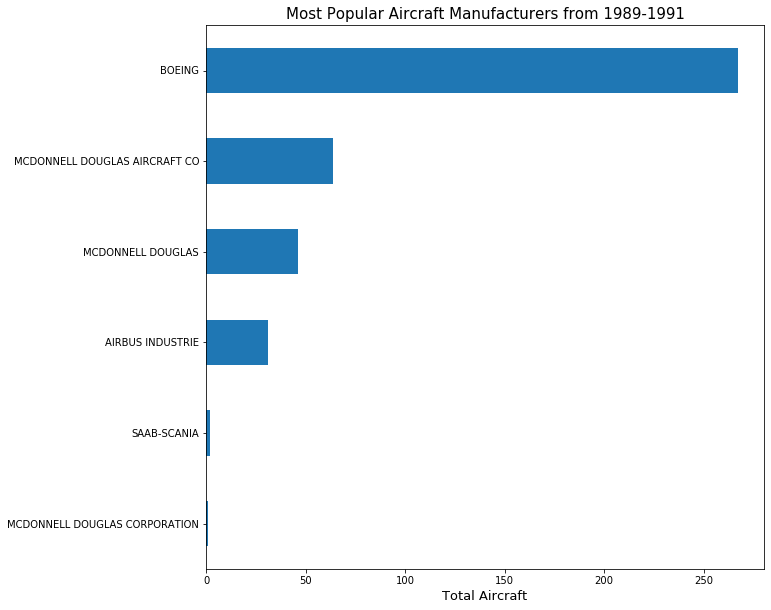

In [135]:
# Most popular aircraft manufacturers between 89-91
plane_data_8991['manufacturer'].value_counts().iloc[0:10].sort_values(ascending=True).plot(kind='barh', figsize=(10,10))

# Title
plt.title('Most Popular Aircraft Manufacturers from 1989-1991', fontsize=15)

# Label
plt.xlabel('Total Aircraft', fontsize=13)

# Plot
plt.savefig('images/charts/top_manufacturers.png')
plt.show()

Which aircraft manufacturer is the most popular, and what is the market distribution like? Boeing is the most popular aircraft manufacturer by far which is no surprise. McDonnell Douglas takes 2nd and 3rd spot. Perhaps we can see which models are the most popular?

In [136]:
# Top manufacturers
plane_data_8991['manufacturer'].value_counts().iloc[0:10].sort_values(ascending=False)

BOEING                           267
MCDONNELL DOUGLAS AIRCRAFT CO     64
MCDONNELL DOUGLAS                 46
AIRBUS INDUSTRIE                  31
SAAB-SCANIA                        2
MCDONNELL DOUGLAS CORPORATION      1
Name: manufacturer, dtype: int64

In [137]:
# Market share
plane_data_8991['manufacturer'].value_counts(normalize=True)

BOEING                           0.649635
MCDONNELL DOUGLAS AIRCRAFT CO    0.155718
MCDONNELL DOUGLAS                0.111922
AIRBUS INDUSTRIE                 0.075426
SAAB-SCANIA                      0.004866
MCDONNELL DOUGLAS CORPORATION    0.002433
Name: manufacturer, dtype: float64

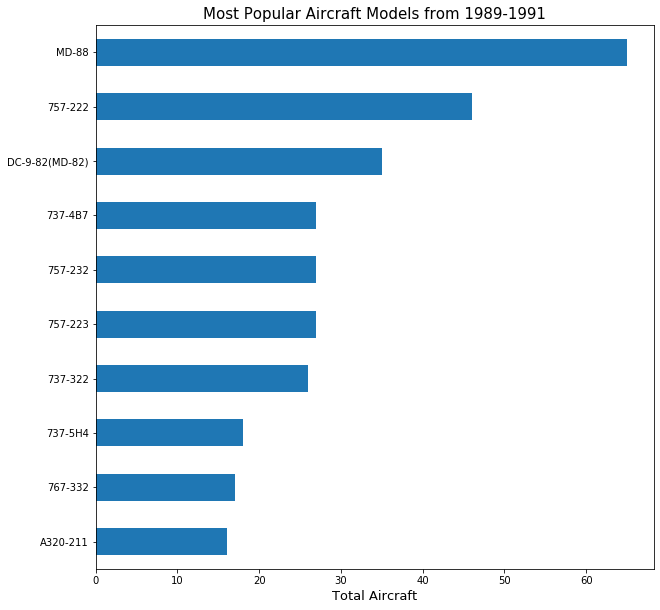

In [138]:
# Most popular aircraft maodels between 89-91
plane_data_8991['model'].value_counts().iloc[0:10].sort_values(ascending=True).plot(kind='barh', figsize=(10,10))

# Title
plt.title('Most Popular Aircraft Models from 1989-1991', fontsize=15)

# Label
plt.xlabel('Total Aircraft', fontsize=13)

# Plot
plt.savefig('images/charts/top_models.png')
plt.show()

We know Boeing is the most popular aircraft manufacturer but what aircraft model is the most popular? MD-88 has the most popular aircraft model which is interesting since Boeing dominates the market. Boeing still has 7 aircraft in the top 10 though. What about engine types?

In [139]:
# Top 10 aircraft from 89-91
plane_data_8991['model'].value_counts().iloc[0:10].sort_values(ascending=False)

MD-88             65
757-222           46
DC-9-82(MD-82)    35
737-4B7           27
757-232           27
757-223           27
737-322           26
737-5H4           18
767-332           17
A320-211          16
Name: model, dtype: int64

In [140]:
# Percent change between values
plane_data_8991['model'].value_counts().iloc[0:10].sort_values(ascending=False).pct_change()

MD-88                  NaN
757-222          -0.292308
DC-9-82(MD-82)   -0.239130
737-4B7          -0.228571
757-232           0.000000
757-223           0.000000
737-322          -0.037037
737-5H4          -0.307692
767-332          -0.055556
A320-211         -0.058824
Name: model, dtype: float64

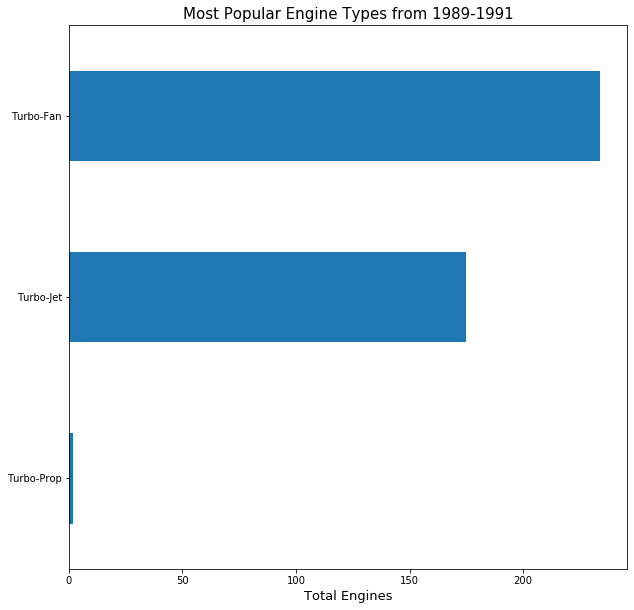

In [141]:
# Most popular engine types between 89-91
plane_data_8991['engine_type'].value_counts().iloc[0:10].sort_values(ascending=True).plot(kind='barh', figsize=(10,10))

# Title
plt.title('Most Popular Engine Types from 1989-1991', fontsize=15)

# Label
plt.xlabel('Total Engines', fontsize=13)

# Plot
plt.savefig('images/charts/top_engine_types.png')
plt.show()

What is the most popular engine type? The most common engine type is Turbo-Fan with 234 records, followed by Turbo-Jet with 175 then Turbo-Prop with just 2 records.

**Observation:** Boeing is by far the most popular aircraft manufacturer between 1989 and 1991 with 267 aircraft totalling 65% of the market. The top 6 is rounded out by McDonnel Douglas and Airbus Industrie while SAAB-Scania and MD Corporation rank 5th and 6th. Interestingly, despite Boeing's dominance the most popular aircraft is a McDonnel Douglas MD-88 with 65 aircraft recorded over our 3 year sample. The rest of the top 10 is dominated by 7 Boeing aircraft, 3rd spot is filled by a McDonnel Douglas DC-9 and 10th is taken by an Airbus A320-211. Finally on engine types, the most common engine type is Turbo-Fan with 234 records, followed by Turbo-Jet with 175 then Turbo-Prop with just 2 records.

In [142]:
plane_data_8991['engine_type'].value_counts().iloc[0:10].sort_values(ascending=False)

Turbo-Fan     234
Turbo-Jet     175
Turbo-Prop      2
Name: engine_type, dtype: int64

<a id='conclusion'></a>
## Step 7: Conclusion 📝

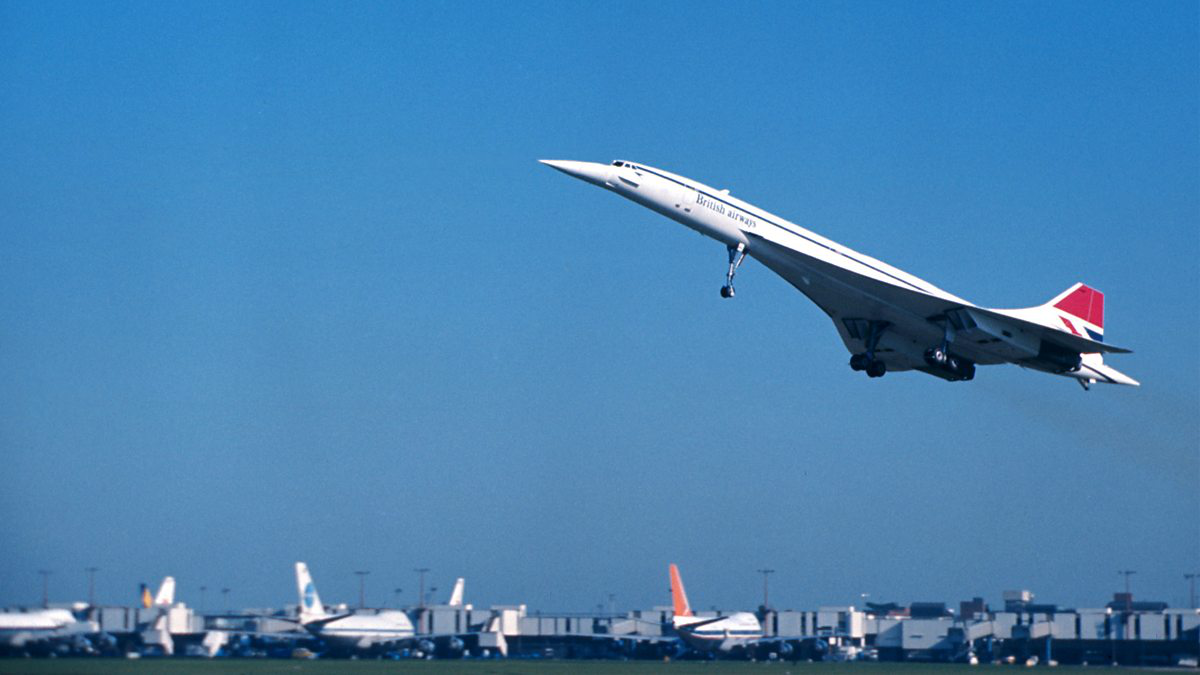

In [143]:
Image.open('images/concorde.jpg')

### 7.1. Interesting Findings

From our data, we can assess passengers fly more during the summer and least during the winter and more during midweek versus the weekend. The most popular time to travel for passengers is in the morning around 8:00. Most flights average a 110 minute flight time and an average distance is 632 miles. Interestingly, the average distance for flights increases during the winter months suggesting that passengers commute further to go on distant holidays or visit family and friends across the country. Airline carriers enjoy a competitive market with no more than 36% difference in total flights between carriers. Regarding carriers, we observed that flight delays increase with flight distance. Chicago O'Hare International is the busiest airport with over 1.5 million flights recorded over the 3 year period.

### 7.2. Project Answers

**How many flights are there?**\
15,031,014 flights.

**Which airlines have the most flights?**\
US Airways Inc.

**What time of the week passengers fly the most?**\
Monday to Friday.

**How does season change the frequency and the destination of travel?**\
Summer increases the frequency of average flights whilst winter decreases it.

**Which routes are the most popular?**
1. SFO - LAX | 69,180 Flights 
2. LAX - SFO | 68,754 Flights
3. LAX - PHX | 39,321 Flights

*LAX: Los Angeles Intl, SFO: San Fransisco Intl, PHX: Phoenix Sky Harbor Intl.*

**Which routes and airports experience the most delays?**\
GUC - HDN Gunisson to Haydon | 1980 minutes on average for route.\
PSE Mercedita Airport | 53.25 minutes delay on average is the highest for an airport.\
BQN Rafael Hernández Airport | -10.35 minutes delay (early) on average is lowest for an airport.

**Which airports are the busiest in terms of inbound and outbound flights?**\
Chicago O'Hare International.

**Which popular routes are delayed the most?**\
LAX - SFO |	68,754 Flights, 18.97 minutes delay on average.\
PHX - LAX |	38,756 Flights, 16.18 minutes delay on average.\
PHX - LAS |	30,778 Flights, 15.85 minutes delay on average.

**Which times are airports the busiest in terms of flights by each hour?**\
08:00 - 09:00 has over 1 million flights during the morning.

**How does flight distance affect departure and arrival delays?**\
Flight distance increases total departure and arrival delays with 0.221398 positive correlation.

**Which airline experiences the fewest delays?**\
Northwest Airlines.


### 7.3. Key Insights for Presentation

For the presentation, I decided to look at flight counts using simple vertical and horizontal bar charts before moving on to more complex plots for deeper analysis. I used an area plot for flight duration because it looked visually clearer than using a line chart. I used a histogram for the flight distance plot to keep things interesting since my plan was to use many different plot types for the slides. 

For total flights by carrier I decided to use a colourful pie chart which should catch the audiences attention since unique and vibrant colour selection is important. I also decided to explode the largest slice of the pie chart. For the delay section I used a combination of line charts and horizontal bar charts since it was the best way to show bivariate data that relies on categorical data. Next, I introduced a third variable which was categorical so I decided to use a heatmap. Heatmaps are great at showing multiple dimensions of data in a fun way, in our case it was for airport name, flight totals, and month. The darker the colour the more flights per grid box.

I used a combination chart to plot airlines vs month vs average distance. This allowed me to show multiple variables co-existing in the same axis clearly. Average flight delay vs distance used the scatterplot, another plot I was keen to try as it engages the audience with raw individual data points. This allowed us to use a line of best fit to intercept the points to see if there was a correlation visually. For routes by flights vs airline average delay it was the perfect time to use a grouped bar chart, I found some interesting colour palettes for my chart from coolor.co. I could plot multiple airlines for each route on the same bar axis and take an average of them if we wanted to. I used a swarm plot on the same data for another angle to see if we could find out more. Average airlines by delay had a similar treatment with the grouped bar chart instead replacing routes with airline carriers, this time I used a more modest colour palette. The random exploration at the end used simple bar charts again as they are a quick and easy to explore data.

#### References
Getting csv subdirectories: https://perials.com/getting-csv-files-directory-subdirectories-using-python/ \
Combine csv files: https://www.freecodecamp.org/news/how-to-combine-multiple-csv-files-with-8-lines-of-code-265183e0854/ \
Fix .info() display: https://www.geeksforgeeks.org/python-pandas-dataframe-info/ \
CMD: https://www.tomnash.eu/how-to-combine-multiple-csv-files-into-one-using-cmd/ \
Reset and drop index: https://stackoverflow.com/questions/39616424/pandas-reset-index-creating-level0-column \
Between values 1: https://stackoverflow.com/questions/31617845/how-to-select-rows-in-a-dataframe-between-two-values-in-python-pandas \
Between values 2: https://www.geeksforgeeks.org/python-pandas-series-between/ \
String Pad or str.pad: https://www.geeksforgeeks.org/python-pandas-series-str-pad/ \
String Slicing: https://geekflare.com/python-remove-last-character/ \
Datetime without date: https://stackoverflow.com/questions/32375471/pandas-convert-strings-to-time-without-date# \
Replace values: https://datatofish.com/replace-values-pandas-dataframe/ \
Dates to seasons: https://stackoverflow.com/questions/22615288/group-data-by-seasons-using-python-and-pandas \
Rename Index: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename_axis.html \
Sort Index by list: https://stackoverflow.com/questions/45389126/sort-index-by-list-python-pandas \
Loc: https://www.geeksforgeeks.org/python-pandas-dataframe-loc/ \
DT Day of Week: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html \
Pandas Interate Dataframe: https://pythonbasics.org/pandas-iterate-dataframe/ \
Strip strings inside bracket: https://stackoverflow.com/questions/20894525/how-to-remove-parentheses-and-all-data-within-using-pandas-python \
Adding colour to pie charts: https://www.pythonprogramming.in/how-to-pie-chart-with-different-color-themes-in-matplotlib.html \
Using axvline to add average line: https://stackoverflow.com/questions/45724329/let-axvline-end-at-certain-y-value \
Plot MultiIndex = https://stackoverflow.com/questions/54451127/creating-a-heatmap-from-a-pandas-multiindex-series \
Modify sns heatmaps: https://stackoverflow.com/questions/42712304/seaborn-heatmap-subplots-keep-axis-ratio-consistent \
Marker styles: https://matplotlib.org/3.1.1/api/markers_api.html \
Sum text columns: https://cmdlinetips.com/2018/11/how-to-join-two-text-columns-into-a-single-column-in-pandas/ \
Melting Dataframe: https://pandas.pydata.org/docs/reference/api/pandas.melt.html \
Concat Dataframe: https://www.geeksforgeeks.org/python-pandas-merging-joining-and-concatenating/ \
Change Seaborn plot size: https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot \
Rename Seaborn legend: https://stackoverflow.com/questions/53116532/modify-seaborn-line-relplot-legend-title \
Rename Columns: https://chartio.com/resources/tutorials/how-to-rename-columns-in-the-pandas-python-library/ \
Plot 3 variable bar chart: https://stackoverflow.com/questions/42128467/matplotlib-plot-multiple-columns-of-pandas-data-frame-on-the-bar-chart \
Filter between two values: https://stackoverflow.com/questions/31617845/how-to-select-rows-in-a-dataframe-between-two-values-in-python-pandas/40442778 \
Drop rows matching string: https://stackoverflow.com/questions/28679930/how-to-drop-rows-from-pandas-data-frame-that-contains-a-particular-string-in-a-p \
Percentage of value_counts = https://stackoverflow.com/questions/14281871/given-a-pandas-series-that-represents-frequencies-of-a-value-how-can-i-turn-tho

In [150]:
!jupyter nbconvert communicate_data_findings.ipynb --to slides --post serve  --no-input --no-prompt

[NbConvertApp] Converting notebook communicate_data_findings.ipynb to slides
[NbConvertApp] Writing 4975195 bytes to communicate_data_findings.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "D:\Users\Ags91\Anaconda3\Scripts\jupyter-nbconvert-script.py", line 9, in <module>
    sys.exit(main())
  File "C:\Users\Ags91\AppData\Roaming\Python\Python37\site-packages\jupyter_core\application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\Ags91\AppData\Roaming\Python\Python37\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Ags91\AppData\Roaming\Python\Python37\site-packages\nbconvert\nbconvertapp.py", line 340, in start
    self.convert_notebooks()
  File "C:\Users\Ags91\AppData\Roaming\Python\Python37\site-packages\nbconvert\nbconvertapp.py", line 